In [1]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py
import subprocess 

import IPython

#from pydub import AudioSegment
#from td_utils import *

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!jupyter kernelspec list

Available kernels:
  deepl      /export/home1/users/bssn/serna/.local/share/jupyter/kernels/deepl
  python3    /export/home1/users/bssn/serna/.local/share/jupyter/kernels/python3


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7690791787200894012
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7907914548
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12316373010659620866
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [4]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.regularizers import L1L2
from keras import backend as K
from keras.layers import MaxPooling1D, AveragePooling1D,Conv1D,SeparableConv1D,GlobalAveragePooling1D
from keras.layers import Lambda
from keras.backend import transpose
from keras import regularizers
#K.int_shape()

Using TensorFlow backend.


In [5]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [6]:
pars = load("Training/roival.npy")
print(len(pars),pars)

1015 [0 0 0 ... 0 0 0]


It is not a NR


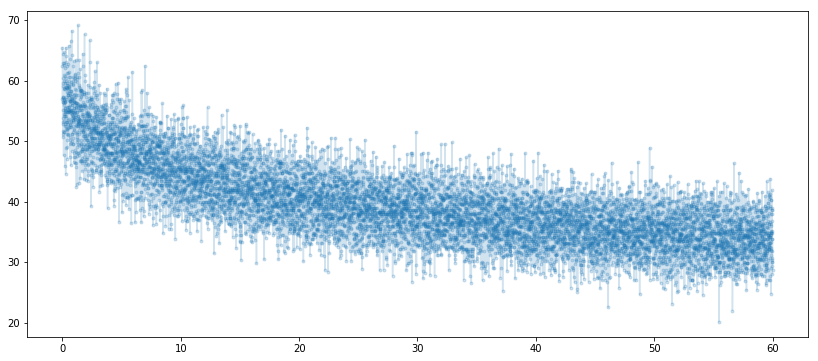

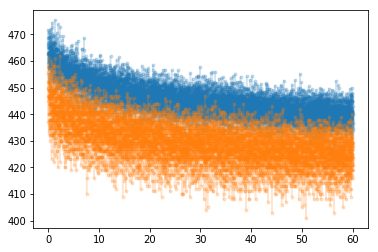

In [7]:
i = randint(0,len(pars))
Ft = load("Training/roi"+str(i).zfill(4)+".npy")
t = arange(Ft.shape[0])*5e-3
if pars[i] == 0:
    print("It is not a NR")
else:
    print("It is a NR")
    
figure(figsize= (14,6))
plot(t,mean(Ft-Ft.min(axis=0),axis=1),'.-',alpha=0.2)
figure()
plot(t,mean(Ft,axis=1),'.-',alpha=0.2)
plot(t,Ft.min(axis=1),'.-',alpha=0.2)

In [8]:
def getdataextract(xt,nframes=1000,selection = True):
    duration, roisize = xt.shape
    if selection:
        start,end = get_random_time_segment(nframes,total_frames=duration)
        xtt = xt[start:end,:].transpose()
    else:
        xtt = xt.transpose()
    s1 = xtt.mean()
    s0 = xtt.std()/s1
    s2 = xtt.std()
    s3 = mean((xtt-s1)**3)/s2**3
    s4 = mean((xtt-s1)**4)/s2**4
    xtt0 = xtt.min(axis=0)
    xtt = xtt-xtt.min(axis=0)
    xtt = xtt.mean(axis=0)
    xtt0 = xtt0/xtt0.mean()
    xtt = xtt/xtt.mean()
    s1n = xtt.mean()
    s2n = xtt.std()
    s3n = mean((xtt-s1n)**3)/s2n**3
    s4n = mean((xtt-s1n)**4)/s2n**4
    s0t = array([s2,s3,s4,(s3**2+1)/s4,s2n,s3n,s4n,(s3**2+1)/s4])
    xtt = concatenate((s0t,xtt,xtt0))
    return(xtt)

In [9]:
# 1 segundo. This will be used as another (meta)parameter, 
# which we want to decrease
nframes = 1000 
pars = load("Training/roival.npy")

lpar = len(pars)

X = []
Y = []
for i in permutation(lpar-200):
    xt = load("Training/roi"+str(i).zfill(4)+".npy")
    par = pars[i]
    nj = 3
    if par == 1: nj = 8
    for j in range(nj):
        X.append(getdataextract(xt))
        #Y.append(concatenate((yt[start:end],par[-1:])))
        Y.append(par)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

Xdev = []
Ydev = []
for i in range(lpar-200,lpar):
    xt = load("Training/roi"+str(i).zfill(4)+".npy")
    par = pars[i]
    for j in range(5):
        Xdev.append(getdataextract(xt))
        #Ydev.append(concatenate((yt[start:end],par[-1:])))
        Ydev.append(par)
Xdev = array(Xdev)
Ydev = array(Ydev)

print(Xdev.shape, Ydev.shape)


'''
Xdev = array(X).transpose()
Ydev = array(Y).transpose()
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    for j in range(20):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        Ydev.append(yt[start:end])
'''        
        

(3465, 2008) (3465,)
(1000, 2008) (1000,)


'\nXdev = array(X).transpose()\nYdev = array(Y).transpose()\nfor i in range(4000,4100):\n    xt = load("syndat/d"+str(i).zfill(4)+".npy")\n    yt = load("syndat/r"+str(i).zfill(4)+".npy")\n    for j in range(20):\n        start,end = get_random_time_segment(nframes)\n        Xdev.append(xt[start:end])\n        Ydev.append(yt[start:end])\n'

It is a NR


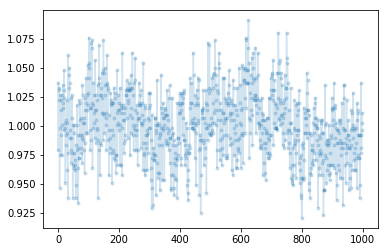

In [10]:
colors = array(['C0','C1'])
t = arange(nframes)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[0])

if Y[i] == 0:
    print("It is not a NR")
else:
    print("It is a NR")

#plot(t,X[i,8:1008],'.-',alpha=0.2)

plot(t,X[i,1008:2008],'.-',alpha=0.2)


In [11]:
X.shape

(3465, 2008)

In [12]:
sum(Y==1)

1632

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [13]:
X = reshape(X,(X.shape[0],X.shape[1],1))
Y = reshape(Y,(Y.shape[0],1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],1))
Ydev = reshape(Ydev,(Ydev.shape[0],1))

print(X.shape,Y.shape)

(3465, 2008, 1) (3465, 1)


In [14]:
# BottleNeck layer
def BNlayer(X, k = 12, c = 3):
    Xa = BatchNormalization()(X)
    Xa = Activation("relu")(Xa)  
    Xa = Conv1D(4*k,1,strides=1,padding="same")(Xa)

    Xa = BatchNormalization()(Xa)
    Xa = Activation("relu")(Xa)  
    Xa = Conv1D(k,c,strides=1,padding="same")(Xa)
    return(Xa)

def DenseBlock(X,nlayers = 6, k=12,c=3):
    Xt = X
    Xa = BNlayer(Xt,k,c)
    if nlayers>1:
        for i in range(nlayers):
            Xt = Concatenate()([Xt,Xa])
            Xa = BNlayer(Xt,k,c)
            
    Xt = Concatenate()([Xt,Xa])
    return(Xt)

def Transitionlayer(X,k=12,s = 2):
    Xa = BatchNormalization()(X)
    Xa = Activation("relu")(Xa) 
    Xa = Conv1D(k,1,strides=1,padding="same")(Xa)
    Xa = AveragePooling1D(2,strides=s,padding="same")(Xa)
    return(Xa)

def modelF(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    tf_session = K.get_session()
    
    X_input = Input(shape = input_shape)
    
    # Layers

    X = X_input
    
    n0par = 8
    n1par = 1008
    Xa = Lambda(lambda x: x[:,n1par:,:], output_shape=(n1par-n0par,1))(X)
    Xb = Lambda(lambda x: x[:,n0par:n1par,:], output_shape=(n1par-n0par,1))(X)
    X  = Lambda(lambda x: x[:,:n0par,:], output_shape=(n0par,1))(X)
    X = Reshape((1,n0par))(X)
    Xa = Xa #Concatenate(axis=-1)([Xa,Xb])
    
    Xashape = array(input_shape)
    Xashape[-1] -= 1 
    n1, n2, s = (20,10,4)

    # 1st Conv Layer
    
    #Xa = Dropout(0.2)(Xa)
    Xa = Conv1D(12,7,strides=1,padding="same")(Xa)

    # 1st Dense Block
    
    Xa = Dropout(0.2)(Xa)
    #Xt = Xa
    #X01 = BNlayer(Xt)
    #Xt = Concatenate()([Xt,X01])
    #X02 = BNlayer(Xt)
    #Xt = Concatenate()([Xt,X02])
    #X03 = BNlayer(Xt)
    #Xt = Concatenate()([Xt,X03])
    #X04 = BNlayer(Xt)
    #Xt = Concatenate()([Xt,X04])
    #X05 = BNlayer(Xt)
    #Xt = Concatenate()([Xt,X05])
    #X06 = BNlayer(Xt)
    Xt = DenseBlock(Xa,nlayers=6,k=12,c=3)
    # Transition Layer
    Xt = Dropout(0.2)(Xt)
    Xtd = K.int_shape(Xt)[-1]


    Xa = Transitionlayer(Xt,k=Xtd//4)
   
    # 2nd Dense Block
    
    Xa = Dropout(0.2)(Xa)
    Xt = DenseBlock(Xa,nlayers=12,k=12,c=3)
    # Transition Layer
    Xt = Dropout(0.2)(Xt)
    Xtd = K.int_shape(Xt)[-1]
    Xa = Transitionlayer(Xt,k=Xtd//4)    
    
    # 3rd Dense Block
    
    Xa = Dropout(0.2)(Xa)
    Xt = DenseBlock(Xa,nlayers=24,k=12,c=3)
    # Transition Layer
    Xt = Dropout(0.2)(Xt)
    Xtd = K.int_shape(Xt)[-1]
    Xa = Transitionlayer(Xt,k=Xtd//4) 

    
    # Second part

    Xa = GlobalAveragePooling1D()(Xa)
    Xad = K.int_shape(Xa)
    # Xa = Reshape((1,Xad[1]*Xad[2]))(Xa)
    
    X = GlobalAveragePooling1D()(X)
    X = Concatenate()([X,Xa])
    #X = Xa
    

    


    #X = Dropout(0.2)(X)
    #X = Dense(40,activation="relu")(X)
    #X = BatchNormalization()(X)
    
    #X = Dropout(0.2)(X)
    #X = Dense(20,activation="relu")(X)
    #X = BatchNormalization()(X)
     
    
    #X = Dropout(0.2)(X)
    #X = Dense(4,activation="sigmoid")(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    
    X = Dense(1,activation="sigmoid")(X)

    #X = Xa
    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [15]:
model = modelF(input_shape = (8+nframes*2,1))

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2008, 1)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1000, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 12)     96          lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1000, 12)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

### Fit the model!

In [17]:
from keras.optimizers import SGD

In [33]:
opt = Adam(lr=0.001, beta_1=0.98, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])


In [19]:
Wsave = model.get_weights()
#model.set_weights(Wsave)

In [30]:
def getdataextractb(xt,nframes=1000,selection = True):
    duration, roisize = xt.shape
    if selection:
        start,end = get_random_time_segment(nframes,total_frames=duration)
        xtt = xt[start:end,:].transpose()
    else:
        xtt = xt.transpose()
    xtt = xtt*(1.0+randn(roisize,nframes)*0.02)
    s1 = xtt.mean()
    s0 = xtt.std()/s1
    s2 = xtt.std()
    s3 = mean((xtt-s1)**3)/s2**3
    s4 = mean((xtt-s1)**4)/s2**4
    xtt0 = xtt.min(axis=0)
    xtt = xtt-xtt.min(axis=0)
    xtt = xtt.mean(axis=0)
    xtt0 = xtt0/xtt0.mean()
    xtt = xtt/xtt.mean()
    s1n = xtt.mean()
    s2n = xtt.std()
    s3n = mean((xtt-s1n)**3)/s2n**3
    s4n = mean((xtt-s1n)**4)/s2n**4
    s0t = array([s2,s3,s4,(s3**2+1)/s4,s2n,s3n,s4n,(s3**2+1)/s4])
    xtt = concatenate((s0t,xtt,xtt0))
    return(xtt)


def getdata_R():
    pars = load("/export/home1/users/bssn/serna/Downloads/Classifier/fullimage/moviefull/roival.npy")
    pars = pars[:,2]
    lpar = len(pars)

    X = []
    Y = []
    for i in permutation(lpar-200):
        xt = load("/export/home1/users/bssn/serna/Downloads/Classifier/fullimage/moviefull/roi_F01A"+str(i).zfill(4)+".npy")
        par = pars[i]
        nj = 3
        if par == 1: nj = 3
        for j in range(nj):
            X.append(getdataextractb(xt))
            #Y.append(concatenate((yt[start:end],par[-1:])))
            Y.append(par)
    X = array(X)
    Y = array(Y)
    #print(X.shape, Y.shape)

    X = reshape(X,(X.shape[0],X.shape[1],1))
    Y = reshape(Y,(Y.shape[0],1))   
    return(X,Y)


In [31]:
X,Y = getdata_R()

In [34]:
historys = {}
historys[0] = model.fit(X, Y, batch_size = 100, epochs =20)

#X,Y = getdata(wd+"sdataU.npy")
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

Epoch 1/20
3003/3003 [==============================] - 49s 16ms/step - loss: 0.7922 - acc: 0.4459
Epoch 2/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.7534 - acc: 0.4589
Epoch 3/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.7162 - acc: 0.4775
Epoch 4/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.6872 - acc: 0.5115
Epoch 5/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.6651 - acc: 0.5478
Epoch 6/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.6472 - acc: 0.5934
Epoch 7/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.6298 - acc: 0.6460
Epoch 8/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.6152 - acc: 0.6767
Epoch 9/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.6059 - acc: 0.6866
Epoch 10/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.5929 - acc: 0.7043
Epoch 11/20
3003/3

In [35]:
X,Y = getdata_R()

In [ ]:
for i in range(1,100):
    historys[i] = model.fit(X, Y, batch_size = 100, epochs =20)
    X,Y = getdata_R()
    if i%3 == 0:
        loss, acc = model.evaluate(Xdev, Ydev)
        print("Dev set accuracy = ", acc)
        model.save_weights('classifierDenseLayer20190107temp.h5')

loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

model.save("/mnt/data/Anastasia/classifierDenseLayer20190108.h5")

Epoch 1/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.5165 - acc: 0.7935
Epoch 2/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.5119 - acc: 0.7842
Epoch 3/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.5113 - acc: 0.7882
Epoch 4/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.5090 - acc: 0.7889
Epoch 5/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4999 - acc: 0.7875
Epoch 6/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4987 - acc: 0.7942
Epoch 7/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4937 - acc: 0.7989
Epoch 8/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4905 - acc: 0.7972
Epoch 9/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4882 - acc: 0.7992
Epoch 10/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4861 - acc: 0.7979
Epoch 11/20
3003/30

3003/3003 [==============================] - 13s 4ms/step - loss: 0.4271 - acc: 0.8208
Epoch 4/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4326 - acc: 0.8232
Epoch 5/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4296 - acc: 0.8175
Epoch 6/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4298 - acc: 0.8222
Epoch 7/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4325 - acc: 0.8139
Epoch 8/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4304 - acc: 0.8195
Epoch 9/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4279 - acc: 0.8245
Epoch 10/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4298 - acc: 0.8235
Epoch 11/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4266 - acc: 0.8175
Epoch 12/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4253 - acc: 0.8198
Epoch 13/20
3003/3003 [=====

3003/3003 [==============================] - 13s 4ms/step - loss: 0.4186 - acc: 0.8325
Epoch 6/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4199 - acc: 0.8362
Epoch 7/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4158 - acc: 0.8322
Epoch 8/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4172 - acc: 0.8335
Epoch 9/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4217 - acc: 0.8298
Epoch 10/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4159 - acc: 0.8332
Epoch 11/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4154 - acc: 0.8288
Epoch 12/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4189 - acc: 0.8312
Epoch 13/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4141 - acc: 0.8305
Epoch 14/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4144 - acc: 0.8262
Epoch 15/20
3003/3003 [===

3003/3003 [==============================] - 13s 4ms/step - loss: 0.4100 - acc: 0.8348
Epoch 7/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4082 - acc: 0.8355
Epoch 8/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4099 - acc: 0.8382
Epoch 9/20
3003/3003 [==============================] - 12s 4ms/step - loss: 0.4091 - acc: 0.8318
Epoch 10/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4084 - acc: 0.8318
Epoch 11/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4154 - acc: 0.8318
Epoch 12/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4091 - acc: 0.8348
Epoch 13/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4124 - acc: 0.8322
Epoch 14/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4123 - acc: 0.8308
Epoch 15/20
3003/3003 [==============================] - 13s 4ms/step - loss: 0.4129 - acc: 0.8302
Epoch 16/20
3003/3003 [==

In [240]:
nframes = 1000 

xxt = load("/export/home1/users/bssn/serna/SyntheticData/QDs/syndat/sdata.npy")
print(xxt.shape)
xsh = xxt.shape
pars = xxt[:,-1]
lpar = xsh[0]

X = []
Y = []
for i in permutation(lpar):
    xt = column_stack((xxt[i,:1000],xxt[i,1000:2000]))
    par = pars[i]
    X.append(getdataextractM(xt))
    Y.append(par)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
X = reshape(X,(X.shape[0],X.shape[1],1))
Y = reshape(Y,(Y.shape[0],1))


def getdata(file = "/export/home1/users/bssn/serna/SyntheticData/QDs/syndat/sdata.npy"):
    xxt = load(file)
    xsh = xxt.shape
    pars = xxt[:,-1]
    lpar = xsh[0]
    X = []
    Y = []
    for i in permutation(lpar):
        xt = column_stack((xxt[i,:1000],xxt[i,1000:2000]))
        par = pars[i]
        X.append(getdataextractM(xt))
        Y.append(par)
    X = array(X)
    Y = array(Y)
    X = reshape(X,(X.shape[0],X.shape[1],1))
    Y = reshape(Y,(Y.shape[0],1))
    return(X,Y)

(3000, 2001)
(3000, 2008) (3000,)


In [241]:
historys = {}
p = subprocess.Popen(["python", "/export/home1/users/bssn/serna/SyntheticData/QDs/generatingSCb.py"])
historys[0] = model.fit(X, Y, batch_size = 100, epochs =20)

p.wait()
os.system("cp "+wd+"sdata.npy "+wd+"sdataU.npy")
wd = "/export/home1/users/bssn/serna/anastasia/ROIS_raw/FullMovies/syndat/"
X,Y = getdata(wd+"sdataU.npy")
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

Epoch 1/20
3000/3000 [==============================] - 64s 21ms/step - loss: 0.4452 - acc: 0.7990
Epoch 2/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2948 - acc: 0.9010
Epoch 3/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2478 - acc: 0.9147
Epoch 4/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2235 - acc: 0.9193
Epoch 5/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2052 - acc: 0.9293
Epoch 6/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2031 - acc: 0.9297
Epoch 7/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1836 - acc: 0.9393
Epoch 8/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1792 - acc: 0.9363
Epoch 9/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1683 - acc: 0.9403
Epoch 10/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1617 - acc: 0.9403
Epoch 11/20
3000/3

In [242]:
for i in range(2,100):
    p = subprocess.Popen(["python", "/export/home1/users/bssn/serna/SyntheticData/QDs/generatingSC.py"])
    historys[i] = model.fit(X, Y, batch_size = 100, epochs =20)
    p.wait()
    os.system("cp "+wd+"sdataU.npy "+wd+"sdata"+str(i).zfill(2)+".npy")
    os.system("cp "+wd+"sdata.npy "+wd+"sdataU.npy")
    X,Y = getdata(wd+"sdataU.npy")
    if i%3 == 0:
        loss, acc = model.evaluate(Xdev, Ydev)
        print("Dev set accuracy = ", acc)
        model.save_weights('classifierDenseLayer20190107temp.h5')

loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

model.save("/mnt/data/Anastasia/classifierDenseLayer20190107.h5")

Epoch 1/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1387 - acc: 0.9490
Epoch 2/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1271 - acc: 0.9563
Epoch 3/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1349 - acc: 0.9500
Epoch 4/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1263 - acc: 0.9533
Epoch 5/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1260 - acc: 0.9563
Epoch 6/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1328 - acc: 0.9517
Epoch 7/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1281 - acc: 0.9540
Epoch 8/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1316 - acc: 0.9517
Epoch 9/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1195 - acc: 0.9540
Epoch 10/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1209 - acc: 0.9547
Epoch 11/20
3000/30

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0929 - acc: 0.9637
Epoch 4/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0923 - acc: 0.9650
Epoch 5/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0945 - acc: 0.9670
Epoch 6/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0965 - acc: 0.9640
Epoch 7/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0888 - acc: 0.9657
Epoch 8/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0912 - acc: 0.9670
Epoch 9/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0899 - acc: 0.9657
Epoch 10/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0915 - acc: 0.9653
Epoch 11/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0941 - acc: 0.9637
Epoch 12/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0925 - acc: 0.9647
Epoch 13/20
3000/3000 [=====

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0889 - acc: 0.9670
Epoch 5/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0901 - acc: 0.9680
Epoch 6/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0852 - acc: 0.9697
Epoch 7/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0885 - acc: 0.9673
Epoch 8/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0880 - acc: 0.9683
Epoch 9/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0848 - acc: 0.9687
Epoch 10/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0892 - acc: 0.9663
Epoch 11/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0819 - acc: 0.9707
Epoch 12/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0889 - acc: 0.9667
Epoch 13/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0872 - acc: 0.9697
Epoch 14/20
3000/3000 [====

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0803 - acc: 0.9720
Epoch 7/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0764 - acc: 0.9720
Epoch 8/20
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0821 - acc: 0.9710
Epoch 9/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0819 - acc: 0.9690
Epoch 10/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0798 - acc: 0.9707
Epoch 11/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0837 - acc: 0.9700
Epoch 12/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0769 - acc: 0.9737
Epoch 13/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0795 - acc: 0.9737
Epoch 14/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0813 - acc: 0.9693
Epoch 15/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0805 - acc: 0.9703
Epoch 16/20
3000/3000 [==

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0773 - acc: 0.9713
Epoch 9/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0788 - acc: 0.9707
Epoch 10/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0781 - acc: 0.9693
Epoch 11/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0781 - acc: 0.9723
Epoch 12/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0801 - acc: 0.9717
Epoch 13/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0802 - acc: 0.9697
Epoch 14/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0791 - acc: 0.9703
Epoch 15/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0754 - acc: 0.9747
Epoch 16/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0754 - acc: 0.9733
Epoch 17/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0782 - acc: 0.9710
Epoch 18/20
3000/3000 [

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0821 - acc: 0.9680
Epoch 10/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0812 - acc: 0.9713
Epoch 11/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0792 - acc: 0.9710
Epoch 12/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0824 - acc: 0.9680
Epoch 13/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0831 - acc: 0.9677
Epoch 14/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0783 - acc: 0.9710
Epoch 15/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0816 - acc: 0.9713
Epoch 16/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0781 - acc: 0.9730
Epoch 17/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0821 - acc: 0.9703
Epoch 18/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0792 - acc: 0.9683
Epoch 19/20
3000/3000 

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0790 - acc: 0.9710
Epoch 12/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0768 - acc: 0.9713
Epoch 13/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0790 - acc: 0.9703
Epoch 14/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0741 - acc: 0.9757
Epoch 15/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0798 - acc: 0.9730
Epoch 16/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0764 - acc: 0.9737
Epoch 17/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0763 - acc: 0.9730
Epoch 18/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0747 - acc: 0.9750
Epoch 19/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0783 - acc: 0.9710
Epoch 20/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0793 - acc: 0.9733
Epoch 1/20
3000/3000 [

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0694 - acc: 0.9750
Epoch 14/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0697 - acc: 0.9730
Epoch 15/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0689 - acc: 0.9733
Epoch 16/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0710 - acc: 0.9750
Epoch 17/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0692 - acc: 0.9737
Epoch 18/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0696 - acc: 0.9757
Epoch 19/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0673 - acc: 0.9737
Epoch 20/20
1000/1000 [==============================] - 2s 2ms/step
Dev set accuracy =  0.792
Epoch 1/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0736 - acc: 0.9720
Epoch 2/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0764 - acc: 0.9737
Epoch 3/20
3000/3000 [======

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0803 - acc: 0.9690
Epoch 15/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0801 - acc: 0.9667
Epoch 16/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0790 - acc: 0.9700
Epoch 17/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0794 - acc: 0.9687
Epoch 18/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0813 - acc: 0.9683
Epoch 19/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0818 - acc: 0.9670
Epoch 20/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0803 - acc: 0.9683
Epoch 1/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0701 - acc: 0.9747
Epoch 2/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0680 - acc: 0.9760
Epoch 3/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0673 - acc: 0.9767
Epoch 4/20
3000/3000 [===

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0854 - acc: 0.9703
Epoch 17/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0834 - acc: 0.9680
Epoch 18/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0823 - acc: 0.9693
Epoch 19/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0830 - acc: 0.9697
Epoch 20/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0847 - acc: 0.9700
Epoch 1/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0746 - acc: 0.9723
Epoch 2/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0761 - acc: 0.9720
Epoch 3/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0775 - acc: 0.9690
Epoch 4/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0750 - acc: 0.9733
Epoch 5/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0698 - acc: 0.9747
Epoch 6/20
3000/3000 [=====

3000/3000 [==============================] - 12s 4ms/step - loss: 0.0809 - acc: 0.9690
Epoch 19/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0804 - acc: 0.9710
Epoch 20/20
1000/1000 [==============================] - 2s 2ms/step
Dev set accuracy =  0.769
Epoch 1/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0840 - acc: 0.9687
Epoch 2/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0806 - acc: 0.9693
Epoch 3/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0787 - acc: 0.9693
Epoch 4/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0820 - acc: 0.9683
Epoch 5/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0797 - acc: 0.9703
Epoch 6/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0815 - acc: 0.9720
Epoch 7/20
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0787 - acc: 0.9717
Epoch 8/20
3000/3000 [===========

RuntimeError: Can't decrement id ref count (file write failed: time = Mon Jan  7 22:15:41 2019
, filename = 'classifierDenseLayer20190107temp.h5', file descriptor = 91, errno = 28, error message = 'No space left on device', buf = 0x720ef648, total write size = 3120, bytes this sub-write = 3120, bytes actually written = 18446744073709551615, offset = 2613248)

In [243]:
i

45

In [ ]:
#Wsave_trained1 = model.get_weights()
Wsave_trained2 = model.get_weights()
#Wsave_trained3 = model.get_weights()

In [73]:
figure()
print(history3.history.keys())
#plot(history.history['acc'])
plot(history3.history['acc'])
#plot(history4.history['acc'])

title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
figure()
#plot(history.history['loss'])
plot(history3.history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')


NameError: name 'history3' is not defined

<Figure size 432x288 with 0 Axes>

In [244]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

1000/1000 [==============================] - 2s 2ms/step
Dev set accuracy =  0.27


In [245]:
nframes = 1000 

pars = load("/export/home1/users/bssn/serna/Downloads/Classifier/fullimage/moviefull/roival.npy")
pars = pars[:,2]
lpar = len(pars)

X = []
Y = []
for i in permutation(lpar-200):
    xt = load("/export/home1/users/bssn/serna/Downloads/Classifier/fullimage/moviefull/roi_F01A"+str(i).zfill(4)+".npy")
    par = pars[i]
    nj = 3
    if par == 1: nj = 3
    for j in range(nj):
        X.append(getdataextract(xt))
        #Y.append(concatenate((yt[start:end],par[-1:])))
        Y.append(par)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)

X = reshape(X,(X.shape[0],X.shape[1],1))
Y = reshape(Y,(Y.shape[0],1))


loss, acc = model.evaluate(X, Y)
print("Dev set accuracy = ", acc)

(3003, 2008) (3003,)
3003/3003 [==============================] - 5s 2ms/step
Dev set accuracy =  0.516483516513289


In [162]:
X = reshape(X,(X.shape[0],X.shape[1],1))
Y = reshape(Y,(Y.shape[0],1))

In [267]:
history4 = model.fit(X, Y, batch_size = 50, epochs =100)

Epoch 1/100
3003/3003 [==============================] - 18s 6ms/step - loss: 1.5705 - acc: 0.5205
Epoch 2/100
3003/3003 [==============================] - 18s 6ms/step - loss: 1.2623 - acc: 0.5368
Epoch 3/100
3003/3003 [==============================] - 18s 6ms/step - loss: 1.1776 - acc: 0.5288
Epoch 4/100
3003/3003 [==============================] - 18s 6ms/step - loss: 1.0774 - acc: 0.5504
Epoch 5/100
3003/3003 [==============================] - 18s 6ms/step - loss: 1.0199 - acc: 0.5614
Epoch 6/100
3003/3003 [==============================] - 18s 6ms/step - loss: 1.0175 - acc: 0.5641
Epoch 7/100
 300/3003 [=>............................] - ETA: 15s - loss: 0.9943 - acc: 0.5500

KeyboardInterrupt: 

In [ ]:
Wsave_trained2 = model.get_weights()
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

In [ ]:
figure()
print(history3.history.keys())
#plot(history.history['acc'])
plot(history3.epoch,
1.0-array(history3.history['acc']))
plot(max(array(history3.epoch)*1.0)+array(history4.epoch),1.0-array(history4.history['acc']))
cf= -0.06; plot(10**linspace(0,4,100),(10**linspace(0,4,100))**cf*1.6e-1/100**cf)
xt =  concatenate((history3.epoch,max(array(history3.epoch)*1.0)+array(history4.epoch)))
yt =  concatenate((1.0-array(history3.history['acc']),1.0-array(history4.history['acc'])))

title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
xscale("log")
yscale("log")

figure()
plot(history3.history['loss'])
plot(max(array(history3.epoch)*1.0)+array(history4.epoch),history4.history['loss'])
title('model loss')
ylabel('loss')
xlabel('epoch')

## Synthetic data....

In [147]:
def getdataextractM(xt,nframes=1000,selection = True):
    roisize, duration = xt.shape
    xtt = xt[:,0]
    s1 = xtt.mean()
    s0 = xtt.std()/s1
    s2 = xtt.std()
    s3 = mean((xtt-s1)**3)/s2**3
    s4 = mean((xtt-s1)**4)/s2**4
    xtt0 = xt[:,1]
    xtt0 = xtt0/xtt0.mean()
    xtt = xtt#-xt[:,1]
    xtt = xtt/xtt.mean()
    s1n = xtt.mean()
    s2n = xtt.std()
    s3n = mean((xtt-s1n)**3)/s2n**3
    s4n = mean((xtt-s1n)**4)/s2n**4
    s0t = array([s2,s3,s4,(s3**2+1)/s4,s2n,s3n,s4n,(s3**2+1)/s4])
    #print(xtt.shape,xtt0.shape,s0t.shape)
    xtt = concatenate((s0t,xtt,xtt0))
    return(xtt)

In [148]:
nframes = 1000 

xxt = load("/export/home1/users/bssn/serna/SyntheticData/QDs/syndat/sdata.npy")
print(xxt.shape)
xsh = xxt.shape
pars = xxt[:,-1]
lpar = xsh[0]

X = []
Y = []
for i in permutation(lpar):
    xt = column_stack((xxt[i,:1000],xxt[i,1000:2000]))
    par = pars[i]
    X.append(getdataextractM(xt))
    Y.append(par)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
X = reshape(X,(X.shape[0],X.shape[1],1))
Y = reshape(Y,(Y.shape[0],1))

(3000, 2001)
(3000, 2008) (3000,)


In [149]:
def getdata(file = "/export/home1/users/bssn/serna/SyntheticData/QDs/syndat/sdata.npy"):
    xxt = load(file)
    xsh = xxt.shape
    pars = xxt[:,-1]
    lpar = xsh[0]
    X = []
    Y = []
    for i in permutation(lpar):
        xt = column_stack((xxt[i,:1000],xxt[i,1000:2000]))
        par = pars[i]
        X.append(getdataextractM(xt))
        Y.append(par)
    X = array(X)
    Y = array(Y)
    X = reshape(X,(X.shape[0],X.shape[1],1))
    Y = reshape(Y,(Y.shape[0],1))
    return(X,Y)

In [151]:
historys = {}

historys[0] = model.fit(X, Y, batch_size = 50, epochs =20)

Epoch 1/20
3000/3000 [==============================] - 61s 20ms/step - loss: 0.5390 - acc: 0.7093
Epoch 2/20
3000/3000 [==============================] - 17s 6ms/step - loss: 0.4474 - acc: 0.7810
Epoch 3/20
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3833 - acc: 0.8280
Epoch 4/20
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3599 - acc: 0.8420
Epoch 5/20
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3320 - acc: 0.8550
Epoch 6/20
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3214 - acc: 0.8527
Epoch 7/20
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3208 - acc: 0.8547
Epoch 8/20
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3138 - acc: 0.8567
Epoch 9/20
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2999 - acc: 0.8617
Epoch 10/20
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2953 - acc: 0.8567
Epoch 11/20
3000/3

In [157]:
wd = "/export/home1/users/bssn/serna/anastasia/ROIS_raw/FullMovies/syndat/"
X,Y = getdata(wd+"sdataU.npy")
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

1000/1000 [==============================] - 2s 2ms/step
Dev set accuracy =  0.27


In [158]:
for i in range(2,40):
    p = subprocess.Popen(["python", "/export/home1/users/bssn/serna/SyntheticData/QDs/generatingSC.py"])
    historys[i] = model.fit(X, Y, batch_size = 50, epochs =15)
    p.wait()
    os.system("cp "+wd+"sdataU.npy "+wd+"sdata"+str(i).zfill(2)+".npy")
    os.system("cp "+wd+"sdata.npy "+wd+"sdataU.npy")
    X,Y = getdata(wd+"sdataU.npy")
    if i%3 == 0:
        loss, acc = model.evaluate(Xdev, Ydev)
        print("Dev set accuracy = ", acc)
        model.save_weights('classifierDenseLayer20190107temp.h5')

Epoch 1/15
3000/3000 [==============================] - 18s 6ms/step - loss: 0.2301 - acc: 0.8877
Epoch 2/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2185 - acc: 0.8937
Epoch 3/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2137 - acc: 0.8923
Epoch 4/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2130 - acc: 0.8963
Epoch 5/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2058 - acc: 0.9010
Epoch 6/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2124 - acc: 0.8880
Epoch 7/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2083 - acc: 0.8993
Epoch 8/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2086 - acc: 0.8947
Epoch 9/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2074 - acc: 0.8960
Epoch 10/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2059 - acc: 0.8970
Epoch 11/15
3000/30

3000/3000 [==============================] - 17s 6ms/step - loss: 0.1977 - acc: 0.9047
Epoch 8/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.1991 - acc: 0.8973
Epoch 9/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.1912 - acc: 0.9063
Epoch 10/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.1945 - acc: 0.9023
Epoch 11/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2011 - acc: 0.9057
Epoch 12/15
3000/3000 [==============================] - 18s 6ms/step - loss: 0.1923 - acc: 0.9083
Epoch 13/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2060 - acc: 0.9027
Epoch 14/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2006 - acc: 0.8983
Epoch 15/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.1979 - acc: 0.9020
Epoch 1/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.1861 - acc: 0.9117
Epoch 2/15
3000/3000 [===

KeyboardInterrupt: 

In [159]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

1000/1000 [==============================] - 2s 2ms/step
Dev set accuracy =  0.27


In [ ]:
model.save("/mnt/data/Anastasia/classifierDenseLayer20190107.h5")


In [203]:
loss, acc = model.evaluate(X, Y)
print("Dev set accuracy = ", acc)

ValueError: Error when checking input: expected input_4 to have 3 dimensions, but got array with shape (3003, 2008)

In [23]:
Xb,Yb = getdata(wd+"sdataU.npy")

NameError: name 'getdata' is not defined

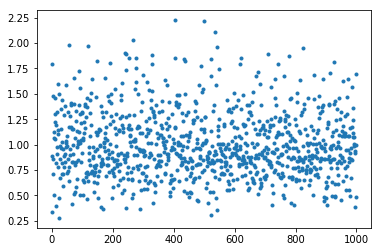

In [29]:
sel = arange(X.shape[0])[Y.flatten()==1]
#selb = arange(Xb.shape[0])[Yb.flatten()==1]
i = randint(0,len(sel))
#j = randint(0,len(selb))
plot(X[sel[i],8:1008,],'.')
#plot(Xb[selb[j],8:1008,],'.')

In [269]:
from scipy.optimize import curve_fit
xt =  concatenate((history3.epoch,max(array(history3.epoch)*1.0)+array(history4.epoch)))
yt =  concatenate((1.0-array(history3.history['acc']),1.0-array(history4.history['acc'])))

dy =  (log((yt[100]-1e-2))-log((yt[1000]-1e-2)))
dx =  (xt[100]-xt[1000])
dlx =  (log(xt[100])-log(xt[1000]))
cf02 = dy/dlx
cf12 = dy/dx
cf01 = log((yt[100]-1e-2)/xt[100]**cf02)
cf11 = log((yt[100]-1e-2)/exp(xt[100]*cf12))

def f0(xt,cf0,cf1,cf2): return(exp(cf0)+exp(cf1+log(xt)*cf2))
def f1(xt,cf0,cf1,cf2): return(exp(cf0)+exp(cf1+xt*cf2))
cf = array([log(1e-2),cf01,cf02])
min0 = curve_fit(f0,xt[100:3000],yt[100:3000],p0=cf,sigma= yt[100:3000]*.01)
cf = array([log(1e-2),cf11,cf12])
min1 = curve_fit(f1,xt[100:3000],yt[100:3000],p0=cf,sigma= yt[100:3000]*.01)

#print(min0.x)

#print(min1.x)
plot(xt,yt)
plot(xt,f1(xt,min1[0][0],min1[0][1],min1[0][2]),'k--')
plot(xt,f0(xt,min0[0][0],min0[0][1],min0[0][2]),'r--')

xscale("log")
yscale("log")
print(exp(min0[0][0]),exp((log(5e-2-exp(min0[0][0]))-min0[0][1])/min0[0][2]))
print(exp(min1[0][0]),(log(5e-2-exp(min1[0][0]))-min1[0][1])/min1[0][2])


NameError: name 'history3' is not defined

In [350]:
#print(min1.x)
min1

(array([-2.03156466e+00, -3.25582698e+00, -1.40743824e-03]),
 array([[ 4.24574578e-07,  4.65360226e-07, -8.90822498e-09],
        [ 4.65360226e-07,  1.35590222e-04, -1.88770191e-07],
        [-8.90822498e-09, -1.88770191e-07,  6.22880858e-10]]))

In [410]:
history4 = model.fit(X, Y, batch_size = 500, epochs =25000)
model.save("classifierFt20181206B.h5")


Epoch 1/25000
3003/3003 [==============================] - 0s 100us/step - loss: 0.3118 - acc: 0.8821
Epoch 2/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3132 - acc: 0.8811
Epoch 3/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3025 - acc: 0.8854
Epoch 4/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3064 - acc: 0.8834
Epoch 5/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3088 - acc: 0.8841
Epoch 6/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3098 - acc: 0.8851
Epoch 7/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3047 - acc: 0.8821
Epoch 8/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3092 - acc: 0.8828
Epoch 9/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3091 - acc: 0.8861
Epoch 10/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3082 - 

3003/3003 [==============================] - 0s 91us/step - loss: 0.3010 - acc: 0.8861
Epoch 161/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3071 - acc: 0.8844
Epoch 162/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3198 - acc: 0.8751
Epoch 163/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3119 - acc: 0.8815
Epoch 164/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3045 - acc: 0.8834
Epoch 165/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3107 - acc: 0.8851
Epoch 166/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3118 - acc: 0.8805
Epoch 167/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.2998 - acc: 0.8861
Epoch 168/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3075 - acc: 0.8838
Epoch 169/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3118 

3003/3003 [==============================] - 0s 92us/step - loss: 0.3062 - acc: 0.8848
Epoch 319/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3203 - acc: 0.8791
Epoch 320/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3112 - acc: 0.8844
Epoch 321/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3123 - acc: 0.8818
Epoch 322/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2995 - acc: 0.8898
Epoch 323/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3062 - acc: 0.8834
Epoch 324/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3240 - acc: 0.8771
Epoch 325/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3063 - acc: 0.8841
Epoch 326/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3104 - acc: 0.8828
Epoch 327/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3064 

3003/3003 [==============================] - 0s 90us/step - loss: 0.3113 - acc: 0.8828
Epoch 477/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3111 - acc: 0.8825
Epoch 478/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3101 - acc: 0.8808
Epoch 479/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3011 - acc: 0.8841
Epoch 480/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3161 - acc: 0.8798
Epoch 481/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3127 - acc: 0.8788
Epoch 482/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3125 - acc: 0.8868
Epoch 483/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3056 - acc: 0.8861
Epoch 484/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3059 - acc: 0.8858
Epoch 485/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3093 

3003/3003 [==============================] - 0s 91us/step - loss: 0.3088 - acc: 0.8834
Epoch 635/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3170 - acc: 0.8735
Epoch 636/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3113 - acc: 0.8828
Epoch 637/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3083 - acc: 0.8871
Epoch 638/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3078 - acc: 0.8844
Epoch 639/25000
3003/3003 [==============================] - 0s 100us/step - loss: 0.3120 - acc: 0.8848
Epoch 640/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.2995 - acc: 0.8894
Epoch 641/25000
3003/3003 [==============================] - 0s 98us/step - loss: 0.3144 - acc: 0.8758
Epoch 642/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3033 - acc: 0.8894
Epoch 643/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3139

3003/3003 [==============================] - 0s 89us/step - loss: 0.3086 - acc: 0.8815
Epoch 793/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3070 - acc: 0.8854
Epoch 794/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3096 - acc: 0.8825
Epoch 795/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3114 - acc: 0.8781
Epoch 796/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3022 - acc: 0.8851
Epoch 797/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3111 - acc: 0.8815
Epoch 798/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3011 - acc: 0.8861
Epoch 799/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3025 - acc: 0.8871
Epoch 800/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3010 - acc: 0.8891
Epoch 801/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3153 

3003/3003 [==============================] - 0s 92us/step - loss: 0.3153 - acc: 0.8765
Epoch 951/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3119 - acc: 0.8811
Epoch 952/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3113 - acc: 0.8831
Epoch 953/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3031 - acc: 0.8878
Epoch 954/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3149 - acc: 0.8791
Epoch 955/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3111 - acc: 0.8834
Epoch 956/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3059 - acc: 0.8834
Epoch 957/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3137 - acc: 0.8741
Epoch 958/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3058 - acc: 0.8848
Epoch 959/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3089 

3003/3003 [==============================] - 0s 93us/step - loss: 0.3122 - acc: 0.8821
Epoch 1108/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3138 - acc: 0.8768
Epoch 1109/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3099 - acc: 0.8844
Epoch 1110/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3057 - acc: 0.8858
Epoch 1111/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3127 - acc: 0.8838
Epoch 1112/25000
3003/3003 [==============================] - 0s 100us/step - loss: 0.3142 - acc: 0.8805
Epoch 1113/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3010 - acc: 0.8861
Epoch 1114/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3132 - acc: 0.8798
Epoch 1115/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3098 - acc: 0.8841
Epoch 1116/25000
3003/3003 [==============================] - 0s 92us/step - los

3003/3003 [==============================] - 0s 91us/step - loss: 0.3166 - acc: 0.8765
Epoch 1264/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3084 - acc: 0.8844
Epoch 1265/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3073 - acc: 0.8811
Epoch 1266/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3068 - acc: 0.8765
Epoch 1267/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3068 - acc: 0.8858
Epoch 1268/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3096 - acc: 0.8831
Epoch 1269/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3133 - acc: 0.8805
Epoch 1270/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3114 - acc: 0.8834
Epoch 1271/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3055 - acc: 0.8834
Epoch 1272/25000
3003/3003 [==============================] - 0s 91us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3097 - acc: 0.8778
Epoch 1420/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3002 - acc: 0.8858
Epoch 1421/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3081 - acc: 0.8801
Epoch 1422/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3128 - acc: 0.8821
Epoch 1423/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3150 - acc: 0.8795
Epoch 1424/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3172 - acc: 0.8815
Epoch 1425/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3050 - acc: 0.8864
Epoch 1426/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3106 - acc: 0.8831
Epoch 1427/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3110 - acc: 0.8808
Epoch 1428/25000
3003/3003 [==============================] - 0s 93us/step - loss

3003/3003 [==============================] - 0s 92us/step - loss: 0.3054 - acc: 0.8854
Epoch 1576/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3142 - acc: 0.8808
Epoch 1577/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3086 - acc: 0.8808
Epoch 1578/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3082 - acc: 0.8858
Epoch 1579/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3069 - acc: 0.8841
Epoch 1580/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3013 - acc: 0.8834
Epoch 1581/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3105 - acc: 0.8838
Epoch 1582/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3071 - acc: 0.8821
Epoch 1583/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3062 - acc: 0.8838
Epoch 1584/25000
3003/3003 [==============================] - 0s 96us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3006 - acc: 0.8914
Epoch 1732/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2999 - acc: 0.8861
Epoch 1733/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3028 - acc: 0.8864
Epoch 1734/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3107 - acc: 0.8818
Epoch 1735/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3069 - acc: 0.8828
Epoch 1736/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3144 - acc: 0.8781
Epoch 1737/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3040 - acc: 0.8808
Epoch 1738/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3107 - acc: 0.8841
Epoch 1739/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3085 - acc: 0.8825
Epoch 1740/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.3168 - acc: 0.8771
Epoch 1888/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3030 - acc: 0.8828
Epoch 1889/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3140 - acc: 0.8765
Epoch 1890/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3086 - acc: 0.8818
Epoch 1891/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3011 - acc: 0.8858
Epoch 1892/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3057 - acc: 0.8861
Epoch 1893/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3085 - acc: 0.8805
Epoch 1894/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3008 - acc: 0.8848
Epoch 1895/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3007 - acc: 0.8861
Epoch 1896/25000
3003/3003 [==============================] - 0s 91us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.3163 - acc: 0.8795
Epoch 2044/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3072 - acc: 0.8828
Epoch 2045/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3042 - acc: 0.8825
Epoch 2046/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3039 - acc: 0.8874
Epoch 2047/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3056 - acc: 0.8844
Epoch 2048/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3088 - acc: 0.8795
Epoch 2049/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3060 - acc: 0.8844
Epoch 2050/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3081 - acc: 0.8858
Epoch 2051/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3029 - acc: 0.8851
Epoch 2052/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 94us/step - loss: 0.3071 - acc: 0.8821
Epoch 2200/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3005 - acc: 0.8871
Epoch 2201/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3049 - acc: 0.8821
Epoch 2202/25000
3003/3003 [==============================] - 0s 98us/step - loss: 0.3056 - acc: 0.8841
Epoch 2203/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3082 - acc: 0.8848
Epoch 2204/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3069 - acc: 0.8831
Epoch 2205/25000
3003/3003 [==============================] - 0s 99us/step - loss: 0.3026 - acc: 0.8901
Epoch 2206/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3101 - acc: 0.8821
Epoch 2207/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3088 - acc: 0.8818
Epoch 2208/25000
3003/3003 [==============================] - 0s 94us/step - loss

3003/3003 [==============================] - 0s 92us/step - loss: 0.3138 - acc: 0.8805
Epoch 2356/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3052 - acc: 0.8848
Epoch 2357/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3069 - acc: 0.8751
Epoch 2358/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3098 - acc: 0.8868
Epoch 2359/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3026 - acc: 0.8861
Epoch 2360/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3091 - acc: 0.8805
Epoch 2361/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3023 - acc: 0.8828
Epoch 2362/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3074 - acc: 0.8848
Epoch 2363/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3053 - acc: 0.8831
Epoch 2364/25000
3003/3003 [==============================] - 0s 92us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3065 - acc: 0.8871
Epoch 2512/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3103 - acc: 0.8801
Epoch 2513/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3045 - acc: 0.8798
Epoch 2514/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3110 - acc: 0.8808
Epoch 2515/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3091 - acc: 0.8821
Epoch 2516/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3051 - acc: 0.8844
Epoch 2517/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3009 - acc: 0.8874
Epoch 2518/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3015 - acc: 0.8878
Epoch 2519/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3003 - acc: 0.8864
Epoch 2520/25000
3003/3003 [==============================] - 0s 96us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.3122 - acc: 0.8834
Epoch 2668/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3126 - acc: 0.8788
Epoch 2669/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3073 - acc: 0.8841
Epoch 2670/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3044 - acc: 0.8851
Epoch 2671/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3060 - acc: 0.8811
Epoch 2672/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3080 - acc: 0.8828
Epoch 2673/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3024 - acc: 0.8844
Epoch 2674/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3047 - acc: 0.8861
Epoch 2675/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3042 - acc: 0.8838
Epoch 2676/25000
3003/3003 [==============================] - 0s 93us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.3122 - acc: 0.8805
Epoch 2824/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3041 - acc: 0.8854
Epoch 2825/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3035 - acc: 0.8838
Epoch 2826/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3042 - acc: 0.8821
Epoch 2827/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3123 - acc: 0.8781
Epoch 2828/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3026 - acc: 0.8861
Epoch 2829/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3091 - acc: 0.8795
Epoch 2830/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3064 - acc: 0.8861
Epoch 2831/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2984 - acc: 0.8868
Epoch 2832/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 93us/step - loss: 0.2993 - acc: 0.8908
Epoch 2980/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3103 - acc: 0.8791
Epoch 2981/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3055 - acc: 0.8851
Epoch 2982/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3060 - acc: 0.8851
Epoch 2983/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3043 - acc: 0.8868
Epoch 2984/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3048 - acc: 0.8795
Epoch 2985/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3039 - acc: 0.8871
Epoch 2986/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3075 - acc: 0.8815
Epoch 2987/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3047 - acc: 0.8858
Epoch 2988/25000
3003/3003 [==============================] - 0s 96us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3104 - acc: 0.8808
Epoch 3136/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3055 - acc: 0.8864
Epoch 3137/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3039 - acc: 0.8848
Epoch 3138/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3089 - acc: 0.8791
Epoch 3139/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2997 - acc: 0.8834
Epoch 3140/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3067 - acc: 0.8815
Epoch 3141/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3054 - acc: 0.8851
Epoch 3142/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3026 - acc: 0.8851
Epoch 3143/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3109 - acc: 0.8868
Epoch 3144/25000
3003/3003 [==============================] - 0s 93us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3112 - acc: 0.8775
Epoch 3292/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3091 - acc: 0.8838
Epoch 3293/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3041 - acc: 0.8768
Epoch 3294/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3086 - acc: 0.8818
Epoch 3295/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3055 - acc: 0.8841
Epoch 3296/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3053 - acc: 0.8854
Epoch 3297/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3123 - acc: 0.8768
Epoch 3298/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3082 - acc: 0.8808
Epoch 3299/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3055 - acc: 0.8841
Epoch 3300/25000
3003/3003 [==============================] - 0s 91us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.3030 - acc: 0.8818
Epoch 3448/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3095 - acc: 0.8838
Epoch 3449/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3014 - acc: 0.8848
Epoch 3450/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3048 - acc: 0.8834
Epoch 3451/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3122 - acc: 0.8798
Epoch 3452/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3000 - acc: 0.8901
Epoch 3453/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3029 - acc: 0.8828
Epoch 3454/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3077 - acc: 0.8844
Epoch 3455/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3048 - acc: 0.8854
Epoch 3456/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 87us/step - loss: 0.3068 - acc: 0.8844
Epoch 3604/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2987 - acc: 0.8834
Epoch 3605/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2987 - acc: 0.8864
Epoch 3606/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3016 - acc: 0.8854
Epoch 3607/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3100 - acc: 0.8805
Epoch 3608/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3028 - acc: 0.8858
Epoch 3609/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3080 - acc: 0.8815
Epoch 3610/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3134 - acc: 0.8825
Epoch 3611/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3066 - acc: 0.8844
Epoch 3612/25000
3003/3003 [==============================] - 0s 91us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3102 - acc: 0.8834
Epoch 3760/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3089 - acc: 0.8858
Epoch 3761/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3058 - acc: 0.8851
Epoch 3762/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3004 - acc: 0.8861
Epoch 3763/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3056 - acc: 0.8798
Epoch 3764/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3137 - acc: 0.8781
Epoch 3765/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3067 - acc: 0.8798
Epoch 3766/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3036 - acc: 0.8844
Epoch 3767/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3082 - acc: 0.8851
Epoch 3768/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 88us/step - loss: 0.3027 - acc: 0.8864
Epoch 3916/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3076 - acc: 0.8864
Epoch 3917/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3041 - acc: 0.8888
Epoch 3918/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3023 - acc: 0.8881
Epoch 3919/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3067 - acc: 0.8811
Epoch 3920/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3057 - acc: 0.8851
Epoch 3921/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3154 - acc: 0.8818
Epoch 3922/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3075 - acc: 0.8825
Epoch 3923/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3077 - acc: 0.8838
Epoch 3924/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 92us/step - loss: 0.3054 - acc: 0.8821
Epoch 4072/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3071 - acc: 0.8841
Epoch 4073/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3035 - acc: 0.8864
Epoch 4074/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3081 - acc: 0.8834
Epoch 4075/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3062 - acc: 0.8848
Epoch 4076/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3088 - acc: 0.8854
Epoch 4077/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3135 - acc: 0.8815
Epoch 4078/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3075 - acc: 0.8808
Epoch 4079/25000
3003/3003 [==============================] - 0s 99us/step - loss: 0.3098 - acc: 0.8848
Epoch 4080/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3077 - acc: 0.8848
Epoch 4228/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3083 - acc: 0.8788
Epoch 4229/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2970 - acc: 0.8904
Epoch 4230/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3034 - acc: 0.8861
Epoch 4231/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3059 - acc: 0.8841
Epoch 4232/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3121 - acc: 0.8765
Epoch 4233/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2924 - acc: 0.8904
Epoch 4234/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3149 - acc: 0.8775
Epoch 4235/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3170 - acc: 0.8811
Epoch 4236/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3083 - acc: 0.8811
Epoch 4384/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3071 - acc: 0.8861
Epoch 4385/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3068 - acc: 0.8854
Epoch 4386/25000
3003/3003 [==============================] - 0s 99us/step - loss: 0.3007 - acc: 0.8848
Epoch 4387/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.2980 - acc: 0.8911
Epoch 4388/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3010 - acc: 0.8874
Epoch 4389/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3084 - acc: 0.8811
Epoch 4390/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3069 - acc: 0.8874
Epoch 4391/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3072 - acc: 0.8818
Epoch 4392/25000
3003/3003 [==============================] - 0s 92us/step - loss

3003/3003 [==============================] - 0s 88us/step - loss: 0.3022 - acc: 0.8874
Epoch 4540/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3017 - acc: 0.8888
Epoch 4541/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3058 - acc: 0.8858
Epoch 4542/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3066 - acc: 0.8815
Epoch 4543/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3028 - acc: 0.8831
Epoch 4544/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3001 - acc: 0.8878
Epoch 4545/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3061 - acc: 0.8831
Epoch 4546/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3068 - acc: 0.8831
Epoch 4547/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3042 - acc: 0.8815
Epoch 4548/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 92us/step - loss: 0.3087 - acc: 0.8878
Epoch 4696/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3043 - acc: 0.8851
Epoch 4697/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3086 - acc: 0.8801
Epoch 4698/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3076 - acc: 0.8834
Epoch 4699/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2997 - acc: 0.8848
Epoch 4700/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3029 - acc: 0.8848
Epoch 4701/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2989 - acc: 0.8841
Epoch 4702/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2999 - acc: 0.8888
Epoch 4703/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3104 - acc: 0.8801
Epoch 4704/25000
3003/3003 [==============================] - 0s 92us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.3100 - acc: 0.8818
Epoch 4852/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3031 - acc: 0.8841
Epoch 4853/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3084 - acc: 0.8851
Epoch 4854/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3089 - acc: 0.8825
Epoch 4855/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3047 - acc: 0.8834
Epoch 4856/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3019 - acc: 0.8878
Epoch 4857/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3112 - acc: 0.8801
Epoch 4858/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2937 - acc: 0.8904
Epoch 4859/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3054 - acc: 0.8858
Epoch 4860/25000
3003/3003 [==============================] - 0s 91us/step - loss

3003/3003 [==============================] - 0s 88us/step - loss: 0.2966 - acc: 0.8898
Epoch 5008/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3087 - acc: 0.8825
Epoch 5009/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3017 - acc: 0.8864
Epoch 5010/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3012 - acc: 0.8834
Epoch 5011/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3043 - acc: 0.8815
Epoch 5012/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3115 - acc: 0.8818
Epoch 5013/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3027 - acc: 0.8825
Epoch 5014/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3077 - acc: 0.8825
Epoch 5015/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3027 - acc: 0.8864
Epoch 5016/25000
3003/3003 [==============================] - 0s 94us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3094 - acc: 0.8825
Epoch 5164/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3083 - acc: 0.8848
Epoch 5165/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3018 - acc: 0.8884
Epoch 5166/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3044 - acc: 0.8881
Epoch 5167/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3090 - acc: 0.8828
Epoch 5168/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3127 - acc: 0.8805
Epoch 5169/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3156 - acc: 0.8791
Epoch 5170/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3039 - acc: 0.8864
Epoch 5171/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3040 - acc: 0.8864
Epoch 5172/25000
3003/3003 [==============================] - 0s 88us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3075 - acc: 0.8828
Epoch 5320/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3112 - acc: 0.8838
Epoch 5321/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3054 - acc: 0.8831
Epoch 5322/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3047 - acc: 0.8811
Epoch 5323/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2995 - acc: 0.8904
Epoch 5324/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3069 - acc: 0.8848
Epoch 5325/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3155 - acc: 0.8801
Epoch 5326/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3065 - acc: 0.8838
Epoch 5327/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3022 - acc: 0.8864
Epoch 5328/25000
3003/3003 [==============================] - 0s 88us/step - loss

3003/3003 [==============================] - 0s 96us/step - loss: 0.3099 - acc: 0.8838
Epoch 5476/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3026 - acc: 0.8818
Epoch 5477/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.2998 - acc: 0.8914
Epoch 5478/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3019 - acc: 0.8874
Epoch 5479/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.2975 - acc: 0.8854
Epoch 5480/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3031 - acc: 0.8825
Epoch 5481/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3006 - acc: 0.8864
Epoch 5482/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3046 - acc: 0.8841
Epoch 5483/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3033 - acc: 0.8815
Epoch 5484/25000
3003/3003 [==============================] - 0s 96us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.2999 - acc: 0.8854
Epoch 5632/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3037 - acc: 0.8848
Epoch 5633/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3089 - acc: 0.8808
Epoch 5634/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2982 - acc: 0.8868
Epoch 5635/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3038 - acc: 0.8888
Epoch 5636/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3109 - acc: 0.8881
Epoch 5637/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2951 - acc: 0.8901
Epoch 5638/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3049 - acc: 0.8821
Epoch 5639/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3034 - acc: 0.8831
Epoch 5640/25000
3003/3003 [==============================] - 0s 92us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3036 - acc: 0.8881
Epoch 5788/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3083 - acc: 0.8868
Epoch 5789/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3134 - acc: 0.8818
Epoch 5790/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3048 - acc: 0.8861
Epoch 5791/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3118 - acc: 0.8798
Epoch 5792/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3099 - acc: 0.8841
Epoch 5793/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3097 - acc: 0.8848
Epoch 5794/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3035 - acc: 0.8874
Epoch 5795/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3043 - acc: 0.8864
Epoch 5796/25000
3003/3003 [==============================] - 0s 92us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3032 - acc: 0.8888
Epoch 5944/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3018 - acc: 0.8901
Epoch 5945/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.2989 - acc: 0.8871
Epoch 5946/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3106 - acc: 0.8811
Epoch 5947/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3055 - acc: 0.8828
Epoch 5948/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3079 - acc: 0.8834
Epoch 5949/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3093 - acc: 0.8851
Epoch 5950/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3018 - acc: 0.8901
Epoch 5951/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3034 - acc: 0.8874
Epoch 5952/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 92us/step - loss: 0.3086 - acc: 0.8831
Epoch 6100/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3017 - acc: 0.8854
Epoch 6101/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3008 - acc: 0.8874
Epoch 6102/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2993 - acc: 0.8884
Epoch 6103/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3095 - acc: 0.8831
Epoch 6104/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3074 - acc: 0.8805
Epoch 6105/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3019 - acc: 0.8844
Epoch 6106/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2989 - acc: 0.8864
Epoch 6107/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3047 - acc: 0.8848
Epoch 6108/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3104 - acc: 0.8821
Epoch 6256/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2989 - acc: 0.8894
Epoch 6257/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3153 - acc: 0.8805
Epoch 6258/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2965 - acc: 0.8874
Epoch 6259/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3013 - acc: 0.8848
Epoch 6260/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3013 - acc: 0.8881
Epoch 6261/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3024 - acc: 0.8864
Epoch 6262/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3128 - acc: 0.8838
Epoch 6263/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3013 - acc: 0.8838
Epoch 6264/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3064 - acc: 0.8878
Epoch 6412/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3019 - acc: 0.8851
Epoch 6413/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3077 - acc: 0.8844
Epoch 6414/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3053 - acc: 0.8821
Epoch 6415/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3041 - acc: 0.8828
Epoch 6416/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3043 - acc: 0.8825
Epoch 6417/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3066 - acc: 0.8844
Epoch 6418/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2917 - acc: 0.8914
Epoch 6419/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3035 - acc: 0.8858
Epoch 6420/25000
3003/3003 [==============================] - 0s 88us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3087 - acc: 0.8795
Epoch 6568/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3056 - acc: 0.8844
Epoch 6569/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3046 - acc: 0.8844
Epoch 6570/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3041 - acc: 0.8808
Epoch 6571/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3029 - acc: 0.8838
Epoch 6572/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3060 - acc: 0.8828
Epoch 6573/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3096 - acc: 0.8874
Epoch 6574/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3014 - acc: 0.8878
Epoch 6575/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3044 - acc: 0.8811
Epoch 6576/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 88us/step - loss: 0.3026 - acc: 0.8838
Epoch 6724/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3026 - acc: 0.8874
Epoch 6725/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3017 - acc: 0.8848
Epoch 6726/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3133 - acc: 0.8791
Epoch 6727/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3073 - acc: 0.8815
Epoch 6728/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3043 - acc: 0.8841
Epoch 6729/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3030 - acc: 0.8838
Epoch 6730/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3078 - acc: 0.8821
Epoch 6731/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3014 - acc: 0.8894
Epoch 6732/25000
3003/3003 [==============================] - 0s 88us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3092 - acc: 0.8841
Epoch 6880/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3004 - acc: 0.8871
Epoch 6881/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.2995 - acc: 0.8874
Epoch 6882/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3028 - acc: 0.8854
Epoch 6883/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3035 - acc: 0.8864
Epoch 6884/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3063 - acc: 0.8861
Epoch 6885/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3082 - acc: 0.8811
Epoch 6886/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3054 - acc: 0.8841
Epoch 6887/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3011 - acc: 0.8841
Epoch 6888/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.3071 - acc: 0.8854
Epoch 7036/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3005 - acc: 0.8818
Epoch 7037/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3080 - acc: 0.8844
Epoch 7038/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3065 - acc: 0.8815
Epoch 7039/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3093 - acc: 0.8828
Epoch 7040/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3071 - acc: 0.8821
Epoch 7041/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3074 - acc: 0.8881
Epoch 7042/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3028 - acc: 0.8851
Epoch 7043/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3082 - acc: 0.8828
Epoch 7044/25000
3003/3003 [==============================] - 0s 91us/step - loss

3003/3003 [==============================] - 0s 88us/step - loss: 0.2992 - acc: 0.8874
Epoch 7192/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3087 - acc: 0.8854
Epoch 7193/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3019 - acc: 0.8868
Epoch 7194/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3074 - acc: 0.8848
Epoch 7195/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3024 - acc: 0.8891
Epoch 7196/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3127 - acc: 0.8791
Epoch 7197/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3026 - acc: 0.8841
Epoch 7198/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3151 - acc: 0.8815
Epoch 7199/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3086 - acc: 0.8844
Epoch 7200/25000
3003/3003 [==============================] - 0s 91us/step - loss

3003/3003 [==============================] - 0s 88us/step - loss: 0.3046 - acc: 0.8841
Epoch 7348/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3007 - acc: 0.8861
Epoch 7349/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3033 - acc: 0.8838
Epoch 7350/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3094 - acc: 0.8871
Epoch 7351/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3054 - acc: 0.8834
Epoch 7352/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3054 - acc: 0.8868
Epoch 7353/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3041 - acc: 0.8854
Epoch 7354/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3093 - acc: 0.8841
Epoch 7355/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3027 - acc: 0.8861
Epoch 7356/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 88us/step - loss: 0.3026 - acc: 0.8878
Epoch 7504/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3036 - acc: 0.8811
Epoch 7505/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3104 - acc: 0.8788
Epoch 7506/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3041 - acc: 0.8851
Epoch 7507/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3061 - acc: 0.8861
Epoch 7508/25000
3003/3003 [==============================] - 0s 97us/step - loss: 0.3102 - acc: 0.8778
Epoch 7509/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3017 - acc: 0.8894
Epoch 7510/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3032 - acc: 0.8844
Epoch 7511/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2999 - acc: 0.8844
Epoch 7512/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3154 - acc: 0.8778
Epoch 7660/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3040 - acc: 0.8861
Epoch 7661/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3043 - acc: 0.8861
Epoch 7662/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2955 - acc: 0.8901
Epoch 7663/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2946 - acc: 0.8868
Epoch 7664/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3068 - acc: 0.8844
Epoch 7665/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3044 - acc: 0.8854
Epoch 7666/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2992 - acc: 0.8894
Epoch 7667/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3059 - acc: 0.8825
Epoch 7668/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 109us/step - loss: 0.3014 - acc: 0.8888
Epoch 7816/25000
3003/3003 [==============================] - 0s 110us/step - loss: 0.3011 - acc: 0.8834
Epoch 7817/25000
3003/3003 [==============================] - 0s 108us/step - loss: 0.2988 - acc: 0.8871
Epoch 7818/25000
3003/3003 [==============================] - 0s 109us/step - loss: 0.3064 - acc: 0.8825
Epoch 7819/25000
3003/3003 [==============================] - 0s 109us/step - loss: 0.2977 - acc: 0.8868
Epoch 7820/25000
3003/3003 [==============================] - 0s 109us/step - loss: 0.3040 - acc: 0.8834
Epoch 7821/25000
3003/3003 [==============================] - 0s 99us/step - loss: 0.3034 - acc: 0.8864
Epoch 7822/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2985 - acc: 0.8891
Epoch 7823/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3077 - acc: 0.8838
Epoch 7824/25000
3003/3003 [==============================] - 0s 89us/step 

3003/3003 [==============================] - 0s 89us/step - loss: 0.3021 - acc: 0.8831
Epoch 7972/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3099 - acc: 0.8848
Epoch 7973/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3078 - acc: 0.8851
Epoch 7974/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3057 - acc: 0.8818
Epoch 7975/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2977 - acc: 0.8831
Epoch 7976/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2999 - acc: 0.8874
Epoch 7977/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3074 - acc: 0.8834
Epoch 7978/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3039 - acc: 0.8858
Epoch 7979/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2983 - acc: 0.8891
Epoch 7980/25000
3003/3003 [==============================] - 0s 88us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3035 - acc: 0.8868
Epoch 8128/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3040 - acc: 0.8848
Epoch 8129/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2999 - acc: 0.8891
Epoch 8130/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3068 - acc: 0.8854
Epoch 8131/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3014 - acc: 0.8884
Epoch 8132/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3142 - acc: 0.8791
Epoch 8133/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2998 - acc: 0.8844
Epoch 8134/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3022 - acc: 0.8841
Epoch 8135/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3046 - acc: 0.8838
Epoch 8136/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.2998 - acc: 0.8884
Epoch 8284/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3012 - acc: 0.8864
Epoch 8285/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3016 - acc: 0.8815
Epoch 8286/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3022 - acc: 0.8871
Epoch 8287/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2963 - acc: 0.8891
Epoch 8288/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3082 - acc: 0.8848
Epoch 8289/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3082 - acc: 0.8821
Epoch 8290/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3055 - acc: 0.8838
Epoch 8291/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2997 - acc: 0.8858
Epoch 8292/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.2998 - acc: 0.8911
Epoch 8440/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3005 - acc: 0.8888
Epoch 8441/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2988 - acc: 0.8871
Epoch 8442/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2981 - acc: 0.8881
Epoch 8443/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.2983 - acc: 0.8888
Epoch 8444/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3012 - acc: 0.8884
Epoch 8445/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3137 - acc: 0.8785
Epoch 8446/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3084 - acc: 0.8808
Epoch 8447/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3065 - acc: 0.8841
Epoch 8448/25000
3003/3003 [==============================] - 0s 88us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3077 - acc: 0.8815
Epoch 8596/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3007 - acc: 0.8888
Epoch 8597/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3058 - acc: 0.8851
Epoch 8598/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3009 - acc: 0.8881
Epoch 8599/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2979 - acc: 0.8861
Epoch 8600/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3052 - acc: 0.8858
Epoch 8601/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3075 - acc: 0.8828
Epoch 8602/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3022 - acc: 0.8811
Epoch 8603/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3061 - acc: 0.8854
Epoch 8604/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.3048 - acc: 0.8848
Epoch 8752/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3041 - acc: 0.8821
Epoch 8753/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3067 - acc: 0.8805
Epoch 8754/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3104 - acc: 0.8818
Epoch 8755/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3071 - acc: 0.8798
Epoch 8756/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2994 - acc: 0.8868
Epoch 8757/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3048 - acc: 0.8841
Epoch 8758/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3026 - acc: 0.8854
Epoch 8759/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3034 - acc: 0.8844
Epoch 8760/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 92us/step - loss: 0.3079 - acc: 0.8778
Epoch 8908/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3075 - acc: 0.8828
Epoch 8909/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3034 - acc: 0.8851
Epoch 8910/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2972 - acc: 0.8928
Epoch 8911/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3043 - acc: 0.8904
Epoch 8912/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3030 - acc: 0.8878
Epoch 8913/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3058 - acc: 0.8834
Epoch 8914/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3087 - acc: 0.8848
Epoch 8915/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3046 - acc: 0.8871
Epoch 8916/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 90us/step - loss: 0.3005 - acc: 0.8898
Epoch 9064/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3038 - acc: 0.8851
Epoch 9065/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3009 - acc: 0.8874
Epoch 9066/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3042 - acc: 0.8821
Epoch 9067/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3102 - acc: 0.8828
Epoch 9068/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3048 - acc: 0.8805
Epoch 9069/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3086 - acc: 0.8868
Epoch 9070/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3038 - acc: 0.8894
Epoch 9071/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3137 - acc: 0.8825
Epoch 9072/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3041 - acc: 0.8848
Epoch 9220/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3089 - acc: 0.8828
Epoch 9221/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3080 - acc: 0.8815
Epoch 9222/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3022 - acc: 0.8861
Epoch 9223/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2912 - acc: 0.8938
Epoch 9224/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3058 - acc: 0.8854
Epoch 9225/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3057 - acc: 0.8825
Epoch 9226/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3088 - acc: 0.8825
Epoch 9227/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3013 - acc: 0.8864
Epoch 9228/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 91us/step - loss: 0.3013 - acc: 0.8848
Epoch 9376/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3039 - acc: 0.8828
Epoch 9377/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3006 - acc: 0.8851
Epoch 9378/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2986 - acc: 0.8891
Epoch 9379/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3072 - acc: 0.8861
Epoch 9380/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3022 - acc: 0.8841
Epoch 9381/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3067 - acc: 0.8858
Epoch 9382/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3047 - acc: 0.8834
Epoch 9383/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2997 - acc: 0.8898
Epoch 9384/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3004 - acc: 0.8864
Epoch 9532/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3134 - acc: 0.8811
Epoch 9533/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2999 - acc: 0.8858
Epoch 9534/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3089 - acc: 0.8815
Epoch 9535/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2962 - acc: 0.8908
Epoch 9536/25000
3003/3003 [==============================] - 0s 98us/step - loss: 0.3002 - acc: 0.8878
Epoch 9537/25000
3003/3003 [==============================] - 0s 86us/step - loss: 0.3031 - acc: 0.8808
Epoch 9538/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3009 - acc: 0.8848
Epoch 9539/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3039 - acc: 0.8858
Epoch 9540/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3068 - acc: 0.8868
Epoch 9688/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3095 - acc: 0.8805
Epoch 9689/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3065 - acc: 0.8808
Epoch 9690/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3017 - acc: 0.8894
Epoch 9691/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3052 - acc: 0.8858
Epoch 9692/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2972 - acc: 0.8878
Epoch 9693/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2988 - acc: 0.8874
Epoch 9694/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3054 - acc: 0.8834
Epoch 9695/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3089 - acc: 0.8825
Epoch 9696/25000
3003/3003 [==============================] - 0s 90us/step - loss

3003/3003 [==============================] - 0s 89us/step - loss: 0.3047 - acc: 0.8878
Epoch 9844/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3089 - acc: 0.8795
Epoch 9845/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3010 - acc: 0.8891
Epoch 9846/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2980 - acc: 0.8874
Epoch 9847/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3008 - acc: 0.8878
Epoch 9848/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2994 - acc: 0.8888
Epoch 9849/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3052 - acc: 0.8844
Epoch 9850/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3021 - acc: 0.8854
Epoch 9851/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3034 - acc: 0.8831
Epoch 9852/25000
3003/3003 [==============================] - 0s 89us/step - loss

3003/3003 [==============================] - 0s 87us/step - loss: 0.3014 - acc: 0.8861
Epoch 10000/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3062 - acc: 0.8834
Epoch 10001/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3048 - acc: 0.8821
Epoch 10002/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3048 - acc: 0.8841
Epoch 10003/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3068 - acc: 0.8811
Epoch 10004/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3044 - acc: 0.8861
Epoch 10005/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3069 - acc: 0.8861
Epoch 10006/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2978 - acc: 0.8854
Epoch 10007/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3024 - acc: 0.8838
Epoch 10008/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3104 - acc: 0.8791
Epoch 10156/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3038 - acc: 0.8861
Epoch 10157/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3038 - acc: 0.8868
Epoch 10158/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2997 - acc: 0.8884
Epoch 10159/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2966 - acc: 0.8851
Epoch 10160/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3097 - acc: 0.8791
Epoch 10161/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3033 - acc: 0.8871
Epoch 10162/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3032 - acc: 0.8864
Epoch 10163/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3017 - acc: 0.8844
Epoch 10164/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.2973 - acc: 0.8884
Epoch 10312/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3018 - acc: 0.8841
Epoch 10313/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2953 - acc: 0.8888
Epoch 10314/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3065 - acc: 0.8825
Epoch 10315/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3087 - acc: 0.8811
Epoch 10316/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3033 - acc: 0.8861
Epoch 10317/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2978 - acc: 0.8864
Epoch 10318/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3041 - acc: 0.8884
Epoch 10319/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3041 - acc: 0.8844
Epoch 10320/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3094 - acc: 0.8828
Epoch 10468/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3044 - acc: 0.8858
Epoch 10469/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3113 - acc: 0.8831
Epoch 10470/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3122 - acc: 0.8828
Epoch 10471/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3077 - acc: 0.8825
Epoch 10472/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3070 - acc: 0.8811
Epoch 10473/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2996 - acc: 0.8918
Epoch 10474/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2985 - acc: 0.8881
Epoch 10475/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3010 - acc: 0.8838
Epoch 10476/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3010 - acc: 0.8858
Epoch 10624/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3076 - acc: 0.8821
Epoch 10625/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2982 - acc: 0.8901
Epoch 10626/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3052 - acc: 0.8841
Epoch 10627/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.2937 - acc: 0.8924
Epoch 10628/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3020 - acc: 0.8888
Epoch 10629/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3041 - acc: 0.8801
Epoch 10630/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3075 - acc: 0.8798
Epoch 10631/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3026 - acc: 0.8881
Epoch 10632/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 96us/step - loss: 0.3095 - acc: 0.8838
Epoch 10780/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3019 - acc: 0.8854
Epoch 10781/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3095 - acc: 0.8818
Epoch 10782/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3079 - acc: 0.8828
Epoch 10783/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2950 - acc: 0.8851
Epoch 10784/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3042 - acc: 0.8834
Epoch 10785/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3056 - acc: 0.8825
Epoch 10786/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2956 - acc: 0.8891
Epoch 10787/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3037 - acc: 0.8841
Epoch 10788/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3071 - acc: 0.8831
Epoch 10936/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3008 - acc: 0.8871
Epoch 10937/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3072 - acc: 0.8834
Epoch 10938/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3012 - acc: 0.8861
Epoch 10939/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3065 - acc: 0.8831
Epoch 10940/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3030 - acc: 0.8801
Epoch 10941/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3016 - acc: 0.8871
Epoch 10942/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3017 - acc: 0.8834
Epoch 10943/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3048 - acc: 0.8851
Epoch 10944/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3004 - acc: 0.8844
Epoch 11092/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3001 - acc: 0.8868
Epoch 11093/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3075 - acc: 0.8841
Epoch 11094/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3049 - acc: 0.8861
Epoch 11095/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3010 - acc: 0.8868
Epoch 11096/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3079 - acc: 0.8808
Epoch 11097/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3001 - acc: 0.8841
Epoch 11098/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3042 - acc: 0.8848
Epoch 11099/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3078 - acc: 0.8815
Epoch 11100/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.2995 - acc: 0.8854
Epoch 11248/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2982 - acc: 0.8854
Epoch 11249/25000
3003/3003 [==============================] - 0s 100us/step - loss: 0.2998 - acc: 0.8888
Epoch 11250/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3051 - acc: 0.8878
Epoch 11251/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3061 - acc: 0.8805
Epoch 11252/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3034 - acc: 0.8808
Epoch 11253/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3022 - acc: 0.8821
Epoch 11254/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3034 - acc: 0.8864
Epoch 11255/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3060 - acc: 0.8815
Epoch 11256/25000
3003/3003 [==============================] - 0s 89us/s

3003/3003 [==============================] - 0s 92us/step - loss: 0.3057 - acc: 0.8861
Epoch 11404/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3023 - acc: 0.8854
Epoch 11405/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3058 - acc: 0.8825
Epoch 11406/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3078 - acc: 0.8834
Epoch 11407/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3063 - acc: 0.8848
Epoch 11408/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3049 - acc: 0.8858
Epoch 11409/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3058 - acc: 0.8834
Epoch 11410/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3010 - acc: 0.8868
Epoch 11411/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2973 - acc: 0.8881
Epoch 11412/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.2987 - acc: 0.8874
Epoch 11560/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3062 - acc: 0.8808
Epoch 11561/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3058 - acc: 0.8818
Epoch 11562/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3074 - acc: 0.8854
Epoch 11563/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3079 - acc: 0.8821
Epoch 11564/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3046 - acc: 0.8825
Epoch 11565/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3134 - acc: 0.8861
Epoch 11566/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3048 - acc: 0.8834
Epoch 11567/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3060 - acc: 0.8838
Epoch 11568/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.3055 - acc: 0.8834
Epoch 11716/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2980 - acc: 0.8858
Epoch 11717/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3060 - acc: 0.8841
Epoch 11718/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3025 - acc: 0.8851
Epoch 11719/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3097 - acc: 0.8834
Epoch 11720/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3040 - acc: 0.8831
Epoch 11721/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3013 - acc: 0.8871
Epoch 11722/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3042 - acc: 0.8861
Epoch 11723/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2953 - acc: 0.8884
Epoch 11724/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3044 - acc: 0.8878
Epoch 11872/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2957 - acc: 0.8884
Epoch 11873/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3000 - acc: 0.8878
Epoch 11874/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3010 - acc: 0.8798
Epoch 11875/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3041 - acc: 0.8831
Epoch 11876/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3036 - acc: 0.8881
Epoch 11877/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2970 - acc: 0.8871
Epoch 11878/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3045 - acc: 0.8821
Epoch 11879/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3015 - acc: 0.8848
Epoch 11880/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.3071 - acc: 0.8828
Epoch 12028/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3114 - acc: 0.8791
Epoch 12029/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2990 - acc: 0.8871
Epoch 12030/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3031 - acc: 0.8861
Epoch 12031/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3035 - acc: 0.8868
Epoch 12032/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3024 - acc: 0.8834
Epoch 12033/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3091 - acc: 0.8798
Epoch 12034/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3078 - acc: 0.8815
Epoch 12035/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3097 - acc: 0.8825
Epoch 12036/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3031 - acc: 0.8844
Epoch 12184/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3108 - acc: 0.8805
Epoch 12185/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3008 - acc: 0.8841
Epoch 12186/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3100 - acc: 0.8815
Epoch 12187/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3053 - acc: 0.8834
Epoch 12188/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3024 - acc: 0.8878
Epoch 12189/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3011 - acc: 0.8858
Epoch 12190/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3033 - acc: 0.8838
Epoch 12191/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3078 - acc: 0.8841
Epoch 12192/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3040 - acc: 0.8844
Epoch 12340/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2928 - acc: 0.8941
Epoch 12341/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3021 - acc: 0.8914
Epoch 12342/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3049 - acc: 0.8821
Epoch 12343/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3005 - acc: 0.8874
Epoch 12344/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3031 - acc: 0.8811
Epoch 12345/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2998 - acc: 0.8868
Epoch 12346/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3064 - acc: 0.8844
Epoch 12347/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3105 - acc: 0.8841
Epoch 12348/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.2987 - acc: 0.8844
Epoch 12496/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2989 - acc: 0.8864
Epoch 12497/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3057 - acc: 0.8851
Epoch 12498/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2978 - acc: 0.8898
Epoch 12499/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2938 - acc: 0.8868
Epoch 12500/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3085 - acc: 0.8841
Epoch 12501/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3001 - acc: 0.8904
Epoch 12502/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3065 - acc: 0.8828
Epoch 12503/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3115 - acc: 0.8788
Epoch 12504/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3030 - acc: 0.8874
Epoch 12652/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2958 - acc: 0.8901
Epoch 12653/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3057 - acc: 0.8825
Epoch 12654/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2982 - acc: 0.8858
Epoch 12655/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3138 - acc: 0.8791
Epoch 12656/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3079 - acc: 0.8838
Epoch 12657/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3030 - acc: 0.8874
Epoch 12658/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2987 - acc: 0.8891
Epoch 12659/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2976 - acc: 0.8901
Epoch 12660/25000
3003/3003 [==============================] - 0s 87us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3070 - acc: 0.8838
Epoch 12808/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2961 - acc: 0.8888
Epoch 12809/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3043 - acc: 0.8815
Epoch 12810/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2986 - acc: 0.8891
Epoch 12811/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3023 - acc: 0.8798
Epoch 12812/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2918 - acc: 0.8931
Epoch 12813/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3038 - acc: 0.8881
Epoch 12814/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3044 - acc: 0.8874
Epoch 12815/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2946 - acc: 0.8928
Epoch 12816/25000
3003/3003 [==============================] - 0s 96us/st

3003/3003 [==============================] - 0s 93us/step - loss: 0.2984 - acc: 0.8884
Epoch 12964/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3030 - acc: 0.8874
Epoch 12965/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3097 - acc: 0.8805
Epoch 12966/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3061 - acc: 0.8841
Epoch 12967/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3020 - acc: 0.8864
Epoch 12968/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3073 - acc: 0.8795
Epoch 12969/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3006 - acc: 0.8884
Epoch 12970/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3062 - acc: 0.8808
Epoch 12971/25000
3003/3003 [==============================] - 0s 97us/step - loss: 0.2961 - acc: 0.8878
Epoch 12972/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 93us/step - loss: 0.3082 - acc: 0.8825
Epoch 13120/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3034 - acc: 0.8828
Epoch 13121/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3043 - acc: 0.8858
Epoch 13122/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3023 - acc: 0.8851
Epoch 13123/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3017 - acc: 0.8888
Epoch 13124/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3041 - acc: 0.8861
Epoch 13125/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2993 - acc: 0.8911
Epoch 13126/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2977 - acc: 0.8871
Epoch 13127/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2982 - acc: 0.8871
Epoch 13128/25000
3003/3003 [==============================] - 0s 92us/st

3003/3003 [==============================] - 0s 93us/step - loss: 0.3000 - acc: 0.8871
Epoch 13276/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3028 - acc: 0.8834
Epoch 13277/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3017 - acc: 0.8864
Epoch 13278/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3005 - acc: 0.8858
Epoch 13279/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2961 - acc: 0.8891
Epoch 13280/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3067 - acc: 0.8858
Epoch 13281/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3016 - acc: 0.8888
Epoch 13282/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3087 - acc: 0.8795
Epoch 13283/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3002 - acc: 0.8884
Epoch 13284/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.2972 - acc: 0.8848
Epoch 13432/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3080 - acc: 0.8831
Epoch 13433/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3015 - acc: 0.8831
Epoch 13434/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2968 - acc: 0.8931
Epoch 13435/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2999 - acc: 0.8864
Epoch 13436/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2951 - acc: 0.8908
Epoch 13437/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2977 - acc: 0.8844
Epoch 13438/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3021 - acc: 0.8848
Epoch 13439/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3101 - acc: 0.8821
Epoch 13440/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.2959 - acc: 0.8924
Epoch 13588/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3068 - acc: 0.8808
Epoch 13589/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3085 - acc: 0.8854
Epoch 13590/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2992 - acc: 0.8874
Epoch 13591/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3013 - acc: 0.8858
Epoch 13592/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3042 - acc: 0.8884
Epoch 13593/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3003 - acc: 0.8884
Epoch 13594/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3014 - acc: 0.8844
Epoch 13595/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2929 - acc: 0.8878
Epoch 13596/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3043 - acc: 0.8891
Epoch 13744/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3060 - acc: 0.8841
Epoch 13745/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3044 - acc: 0.8834
Epoch 13746/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2978 - acc: 0.8858
Epoch 13747/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3090 - acc: 0.8825
Epoch 13748/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2968 - acc: 0.8848
Epoch 13749/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2993 - acc: 0.8881
Epoch 13750/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3085 - acc: 0.8834
Epoch 13751/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3002 - acc: 0.8848
Epoch 13752/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3075 - acc: 0.8864
Epoch 13900/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2954 - acc: 0.8864
Epoch 13901/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3056 - acc: 0.8831
Epoch 13902/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3047 - acc: 0.8838
Epoch 13903/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3031 - acc: 0.8871
Epoch 13904/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3045 - acc: 0.8878
Epoch 13905/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3055 - acc: 0.8838
Epoch 13906/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3036 - acc: 0.8858
Epoch 13907/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3041 - acc: 0.8844
Epoch 13908/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3131 - acc: 0.8801
Epoch 14056/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2930 - acc: 0.8934
Epoch 14057/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3043 - acc: 0.8838
Epoch 14058/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2944 - acc: 0.8904
Epoch 14059/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2935 - acc: 0.8891
Epoch 14060/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3053 - acc: 0.8871
Epoch 14061/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3018 - acc: 0.8861
Epoch 14062/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3063 - acc: 0.8818
Epoch 14063/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3042 - acc: 0.8864
Epoch 14064/25000
3003/3003 [==============================] - 0s 93us/st

3003/3003 [==============================] - 0s 94us/step - loss: 0.2989 - acc: 0.8891
Epoch 14212/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3070 - acc: 0.8828
Epoch 14213/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3013 - acc: 0.8848
Epoch 14214/25000
3003/3003 [==============================] - 0s 97us/step - loss: 0.3007 - acc: 0.8884
Epoch 14215/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3080 - acc: 0.8825
Epoch 14216/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3029 - acc: 0.8868
Epoch 14217/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3029 - acc: 0.8854
Epoch 14218/25000
3003/3003 [==============================] - 0s 98us/step - loss: 0.3060 - acc: 0.8888
Epoch 14219/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3042 - acc: 0.8858
Epoch 14220/25000
3003/3003 [==============================] - 0s 106us/s

3003/3003 [==============================] - 0s 92us/step - loss: 0.3026 - acc: 0.8884
Epoch 14368/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3011 - acc: 0.8851
Epoch 14369/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3021 - acc: 0.8851
Epoch 14370/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3104 - acc: 0.8788
Epoch 14371/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2982 - acc: 0.8878
Epoch 14372/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2961 - acc: 0.8881
Epoch 14373/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3024 - acc: 0.8851
Epoch 14374/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2984 - acc: 0.8898
Epoch 14375/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3125 - acc: 0.8815
Epoch 14376/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.2991 - acc: 0.8838
Epoch 14524/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3045 - acc: 0.8801
Epoch 14525/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3054 - acc: 0.8858
Epoch 14526/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3045 - acc: 0.8871
Epoch 14527/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3011 - acc: 0.8834
Epoch 14528/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3105 - acc: 0.8818
Epoch 14529/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3001 - acc: 0.8864
Epoch 14530/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2948 - acc: 0.8901
Epoch 14531/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2994 - acc: 0.8851
Epoch 14532/25000
3003/3003 [==============================] - 0s 95us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.2974 - acc: 0.8894
Epoch 14680/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.2999 - acc: 0.8854
Epoch 14681/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3011 - acc: 0.8841
Epoch 14682/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3090 - acc: 0.8815
Epoch 14683/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3002 - acc: 0.8904
Epoch 14684/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3063 - acc: 0.8871
Epoch 14685/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2995 - acc: 0.8884
Epoch 14686/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3040 - acc: 0.8851
Epoch 14687/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3053 - acc: 0.8891
Epoch 14688/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3008 - acc: 0.8884
Epoch 14836/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2995 - acc: 0.8874
Epoch 14837/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3071 - acc: 0.8828
Epoch 14838/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3023 - acc: 0.8841
Epoch 14839/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2982 - acc: 0.8904
Epoch 14840/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2957 - acc: 0.8901
Epoch 14841/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2934 - acc: 0.8931
Epoch 14842/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3001 - acc: 0.8838
Epoch 14843/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3102 - acc: 0.8825
Epoch 14844/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3018 - acc: 0.8868
Epoch 14992/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3001 - acc: 0.8878
Epoch 14993/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3015 - acc: 0.8881
Epoch 14994/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3109 - acc: 0.8798
Epoch 14995/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2969 - acc: 0.8861
Epoch 14996/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3035 - acc: 0.8864
Epoch 14997/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3043 - acc: 0.8808
Epoch 14998/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3026 - acc: 0.8821
Epoch 14999/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3029 - acc: 0.8868
Epoch 15000/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.3046 - acc: 0.8871
Epoch 15148/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3021 - acc: 0.8868
Epoch 15149/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3053 - acc: 0.8841
Epoch 15150/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3053 - acc: 0.8838
Epoch 15151/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3017 - acc: 0.8894
Epoch 15152/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3011 - acc: 0.8838
Epoch 15153/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3036 - acc: 0.8841
Epoch 15154/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3099 - acc: 0.8808
Epoch 15155/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3005 - acc: 0.8831
Epoch 15156/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3057 - acc: 0.8825
Epoch 15304/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3051 - acc: 0.8851
Epoch 15305/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2998 - acc: 0.8878
Epoch 15306/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3062 - acc: 0.8831
Epoch 15307/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3101 - acc: 0.8781
Epoch 15308/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2966 - acc: 0.8908
Epoch 15309/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3070 - acc: 0.8844
Epoch 15310/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3027 - acc: 0.8831
Epoch 15311/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2973 - acc: 0.8908
Epoch 15312/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3074 - acc: 0.8851
Epoch 15460/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3079 - acc: 0.8821
Epoch 15461/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2989 - acc: 0.8854
Epoch 15462/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2997 - acc: 0.8871
Epoch 15463/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3054 - acc: 0.8858
Epoch 15464/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3068 - acc: 0.8854
Epoch 15465/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3061 - acc: 0.8861
Epoch 15466/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3078 - acc: 0.8775
Epoch 15467/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3019 - acc: 0.8868
Epoch 15468/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3057 - acc: 0.8818
Epoch 15616/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3075 - acc: 0.8801
Epoch 15617/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2984 - acc: 0.8878
Epoch 15618/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3092 - acc: 0.8841
Epoch 15619/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2926 - acc: 0.8888
Epoch 15620/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3110 - acc: 0.8815
Epoch 15621/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2975 - acc: 0.8891
Epoch 15622/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2970 - acc: 0.8934
Epoch 15623/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3043 - acc: 0.8834
Epoch 15624/25000
3003/3003 [==============================] - 0s 92us/st

3003/3003 [==============================] - 0s 93us/step - loss: 0.3037 - acc: 0.8848
Epoch 15772/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2993 - acc: 0.8908
Epoch 15773/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2930 - acc: 0.8914
Epoch 15774/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.2958 - acc: 0.8904
Epoch 15775/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3049 - acc: 0.8841
Epoch 15776/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3041 - acc: 0.8878
Epoch 15777/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3067 - acc: 0.8815
Epoch 15778/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3044 - acc: 0.8871
Epoch 15779/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3075 - acc: 0.8834
Epoch 15780/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 92us/step - loss: 0.3028 - acc: 0.8864
Epoch 15928/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3031 - acc: 0.8858
Epoch 15929/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3027 - acc: 0.8844
Epoch 15930/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2991 - acc: 0.8861
Epoch 15931/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3068 - acc: 0.8811
Epoch 15932/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3018 - acc: 0.8861
Epoch 15933/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3047 - acc: 0.8851
Epoch 15934/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2844 - acc: 0.8964
Epoch 15935/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3108 - acc: 0.8821
Epoch 15936/25000
3003/3003 [==============================] - 0s 93us/st

3003/3003 [==============================] - 0s 92us/step - loss: 0.3013 - acc: 0.8868
Epoch 16084/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3016 - acc: 0.8871
Epoch 16085/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2992 - acc: 0.8908
Epoch 16086/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3003 - acc: 0.8888
Epoch 16087/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3019 - acc: 0.8871
Epoch 16088/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.2972 - acc: 0.8888
Epoch 16089/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3091 - acc: 0.8851
Epoch 16090/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3056 - acc: 0.8861
Epoch 16091/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3007 - acc: 0.8868
Epoch 16092/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 93us/step - loss: 0.3035 - acc: 0.8825
Epoch 16240/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3044 - acc: 0.8898
Epoch 16241/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2981 - acc: 0.8874
Epoch 16242/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3029 - acc: 0.8868
Epoch 16243/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3018 - acc: 0.8878
Epoch 16244/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3042 - acc: 0.8848
Epoch 16245/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3039 - acc: 0.8854
Epoch 16246/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3146 - acc: 0.8778
Epoch 16247/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3035 - acc: 0.8798
Epoch 16248/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.3033 - acc: 0.8854
Epoch 16396/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3144 - acc: 0.8785
Epoch 16397/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2985 - acc: 0.8904
Epoch 16398/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3055 - acc: 0.8851
Epoch 16399/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3082 - acc: 0.8801
Epoch 16400/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2983 - acc: 0.8904
Epoch 16401/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2977 - acc: 0.8904
Epoch 16402/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3033 - acc: 0.8818
Epoch 16403/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3072 - acc: 0.8821
Epoch 16404/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3023 - acc: 0.8838
Epoch 16552/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3096 - acc: 0.8838
Epoch 16553/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3025 - acc: 0.8878
Epoch 16554/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3028 - acc: 0.8831
Epoch 16555/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3077 - acc: 0.8801
Epoch 16556/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3018 - acc: 0.8854
Epoch 16557/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3033 - acc: 0.8815
Epoch 16558/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3003 - acc: 0.8871
Epoch 16559/25000
3003/3003 [==============================] - 0s 97us/step - loss: 0.3000 - acc: 0.8861
Epoch 16560/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3043 - acc: 0.8851
Epoch 16708/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2988 - acc: 0.8825
Epoch 16709/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3024 - acc: 0.8848
Epoch 16710/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3019 - acc: 0.8834
Epoch 16711/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3054 - acc: 0.8838
Epoch 16712/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2968 - acc: 0.8891
Epoch 16713/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2988 - acc: 0.8841
Epoch 16714/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3059 - acc: 0.8854
Epoch 16715/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2975 - acc: 0.8881
Epoch 16716/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3003 - acc: 0.8871
Epoch 16863/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2968 - acc: 0.8881
Epoch 16864/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3014 - acc: 0.8864
Epoch 16865/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3059 - acc: 0.8861
Epoch 16866/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3029 - acc: 0.8834
Epoch 16867/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3034 - acc: 0.8898
Epoch 16868/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3071 - acc: 0.8811
Epoch 16869/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3012 - acc: 0.8834
Epoch 16870/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3036 - acc: 0.8838
Epoch 16871/25000
3003/3003 [==============================] - 0s 92us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.2994 - acc: 0.8858
Epoch 17019/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2984 - acc: 0.8834
Epoch 17020/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2981 - acc: 0.8914
Epoch 17021/25000
3003/3003 [==============================] - 0s 98us/step - loss: 0.2974 - acc: 0.8918
Epoch 17022/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3042 - acc: 0.8818
Epoch 17023/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3055 - acc: 0.8851
Epoch 17024/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3015 - acc: 0.8888
Epoch 17025/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2954 - acc: 0.8888
Epoch 17026/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3011 - acc: 0.8871
Epoch 17027/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 92us/step - loss: 0.2991 - acc: 0.8881
Epoch 17175/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3098 - acc: 0.8798
Epoch 17176/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2993 - acc: 0.8881
Epoch 17177/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3047 - acc: 0.8851
Epoch 17178/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3050 - acc: 0.8874
Epoch 17179/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3071 - acc: 0.8795
Epoch 17180/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3093 - acc: 0.8811
Epoch 17181/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3091 - acc: 0.8821
Epoch 17182/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3031 - acc: 0.8825
Epoch 17183/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 92us/step - loss: 0.2991 - acc: 0.8868
Epoch 17331/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3043 - acc: 0.8838
Epoch 17332/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3056 - acc: 0.8801
Epoch 17333/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3020 - acc: 0.8858
Epoch 17334/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3089 - acc: 0.8834
Epoch 17335/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3015 - acc: 0.8861
Epoch 17336/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2970 - acc: 0.8901
Epoch 17337/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3093 - acc: 0.8788
Epoch 17338/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3024 - acc: 0.8894
Epoch 17339/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 97us/step - loss: 0.3049 - acc: 0.8788
Epoch 17487/25000
3003/3003 [==============================] - 0s 100us/step - loss: 0.3046 - acc: 0.8838
Epoch 17488/25000
3003/3003 [==============================] - 0s 100us/step - loss: 0.3007 - acc: 0.8851
Epoch 17489/25000
3003/3003 [==============================] - 0s 100us/step - loss: 0.3034 - acc: 0.8808
Epoch 17490/25000
3003/3003 [==============================] - 0s 105us/step - loss: 0.3006 - acc: 0.8838
Epoch 17491/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3039 - acc: 0.8874
Epoch 17492/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2987 - acc: 0.8878
Epoch 17493/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2951 - acc: 0.8878
Epoch 17494/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2980 - acc: 0.8871
Epoch 17495/25000
3003/3003 [==============================] - 0s 91u

3003/3003 [==============================] - 0s 94us/step - loss: 0.3100 - acc: 0.8861
Epoch 17565/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3020 - acc: 0.8848
Epoch 17566/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3011 - acc: 0.8825
Epoch 17567/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3041 - acc: 0.8825
Epoch 17568/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3032 - acc: 0.8838
Epoch 17569/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3014 - acc: 0.8831
Epoch 17570/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3050 - acc: 0.8891
Epoch 17571/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2996 - acc: 0.8864
Epoch 17572/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3026 - acc: 0.8884
Epoch 17573/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.2974 - acc: 0.8918
Epoch 17721/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3082 - acc: 0.8858
Epoch 17722/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2969 - acc: 0.8878
Epoch 17723/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3005 - acc: 0.8884
Epoch 17724/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2998 - acc: 0.8864
Epoch 17725/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3017 - acc: 0.8918
Epoch 17726/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3042 - acc: 0.8898
Epoch 17727/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3001 - acc: 0.8884
Epoch 17728/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3075 - acc: 0.8785
Epoch 17729/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3011 - acc: 0.8851
Epoch 17877/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2959 - acc: 0.8901
Epoch 17878/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3049 - acc: 0.8821
Epoch 17879/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3021 - acc: 0.8868
Epoch 17880/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2982 - acc: 0.8911
Epoch 17881/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3036 - acc: 0.8858
Epoch 17882/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2994 - acc: 0.8884
Epoch 17883/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2932 - acc: 0.8901
Epoch 17884/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3070 - acc: 0.8821
Epoch 17885/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3067 - acc: 0.8841
Epoch 18033/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3005 - acc: 0.8825
Epoch 18034/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3041 - acc: 0.8808
Epoch 18035/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3058 - acc: 0.8818
Epoch 18036/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2945 - acc: 0.8908
Epoch 18037/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2983 - acc: 0.8911
Epoch 18038/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3087 - acc: 0.8858
Epoch 18039/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2991 - acc: 0.8858
Epoch 18040/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2965 - acc: 0.8898
Epoch 18041/25000
3003/3003 [==============================] - 0s 87us/st

3003/3003 [==============================] - 0s 92us/step - loss: 0.3078 - acc: 0.8831
Epoch 18189/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3033 - acc: 0.8831
Epoch 18190/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3043 - acc: 0.8828
Epoch 18191/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3092 - acc: 0.8818
Epoch 18192/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3026 - acc: 0.8871
Epoch 18193/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3055 - acc: 0.8825
Epoch 18194/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3016 - acc: 0.8871
Epoch 18195/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3035 - acc: 0.8891
Epoch 18196/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3050 - acc: 0.8874
Epoch 18197/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3093 - acc: 0.8831
Epoch 18345/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2956 - acc: 0.8868
Epoch 18346/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3039 - acc: 0.8851
Epoch 18347/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3044 - acc: 0.8798
Epoch 18348/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2977 - acc: 0.8908
Epoch 18349/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3014 - acc: 0.8901
Epoch 18350/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.2995 - acc: 0.8864
Epoch 18351/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3052 - acc: 0.8854
Epoch 18352/25000
3003/3003 [==============================] - 0s 96us/step - loss: 0.3006 - acc: 0.8868
Epoch 18353/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 94us/step - loss: 0.3001 - acc: 0.8854
Epoch 18501/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3018 - acc: 0.8834
Epoch 18502/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.2976 - acc: 0.8931
Epoch 18503/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3055 - acc: 0.8815
Epoch 18504/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3003 - acc: 0.8848
Epoch 18505/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3013 - acc: 0.8858
Epoch 18506/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3033 - acc: 0.8825
Epoch 18507/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3039 - acc: 0.8871
Epoch 18508/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3047 - acc: 0.8861
Epoch 18509/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.2990 - acc: 0.8888
Epoch 18657/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3017 - acc: 0.8851
Epoch 18658/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3011 - acc: 0.8861
Epoch 18659/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3099 - acc: 0.8834
Epoch 18660/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2975 - acc: 0.8874
Epoch 18661/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2958 - acc: 0.8911
Epoch 18662/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2928 - acc: 0.8881
Epoch 18663/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3072 - acc: 0.8818
Epoch 18664/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3052 - acc: 0.8868
Epoch 18665/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 92us/step - loss: 0.3030 - acc: 0.8868
Epoch 18813/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3043 - acc: 0.8851
Epoch 18814/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3108 - acc: 0.8851
Epoch 18815/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3025 - acc: 0.8851
Epoch 18816/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2995 - acc: 0.8854
Epoch 18817/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3046 - acc: 0.8825
Epoch 18818/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3055 - acc: 0.8838
Epoch 18819/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3038 - acc: 0.8854
Epoch 18820/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2993 - acc: 0.8878
Epoch 18821/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3016 - acc: 0.8898
Epoch 18969/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3052 - acc: 0.8858
Epoch 18970/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2969 - acc: 0.8871
Epoch 18971/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3132 - acc: 0.8825
Epoch 18972/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3066 - acc: 0.8825
Epoch 18973/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3006 - acc: 0.8874
Epoch 18974/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3053 - acc: 0.8844
Epoch 18975/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2992 - acc: 0.8908
Epoch 18976/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.2987 - acc: 0.8878
Epoch 18977/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 94us/step - loss: 0.3000 - acc: 0.8904
Epoch 19125/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3014 - acc: 0.8851
Epoch 19126/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3015 - acc: 0.8888
Epoch 19127/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3098 - acc: 0.8821
Epoch 19128/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2939 - acc: 0.8911
Epoch 19129/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3070 - acc: 0.8808
Epoch 19130/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2996 - acc: 0.8854
Epoch 19131/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3014 - acc: 0.8851
Epoch 19132/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3077 - acc: 0.8838
Epoch 19133/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3013 - acc: 0.8854
Epoch 19281/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2947 - acc: 0.8888
Epoch 19282/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3021 - acc: 0.8854
Epoch 19283/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2983 - acc: 0.8874
Epoch 19284/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3023 - acc: 0.8848
Epoch 19285/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2980 - acc: 0.8884
Epoch 19286/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2973 - acc: 0.8878
Epoch 19287/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3018 - acc: 0.8858
Epoch 19288/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3010 - acc: 0.8864
Epoch 19289/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3011 - acc: 0.8871
Epoch 19437/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3044 - acc: 0.8854
Epoch 19438/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2988 - acc: 0.8898
Epoch 19439/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2977 - acc: 0.8904
Epoch 19440/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3040 - acc: 0.8815
Epoch 19441/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3078 - acc: 0.8821
Epoch 19442/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3025 - acc: 0.8868
Epoch 19443/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2985 - acc: 0.8821
Epoch 19444/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2987 - acc: 0.8868
Epoch 19445/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 96us/step - loss: 0.2975 - acc: 0.8898
Epoch 19593/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3030 - acc: 0.8828
Epoch 19594/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3054 - acc: 0.8831
Epoch 19595/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3005 - acc: 0.8858
Epoch 19596/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3052 - acc: 0.8834
Epoch 19597/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3008 - acc: 0.8854
Epoch 19598/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3074 - acc: 0.8864
Epoch 19599/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2999 - acc: 0.8868
Epoch 19600/25000
3003/3003 [==============================] - 0s 99us/step - loss: 0.3044 - acc: 0.8811
Epoch 19601/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3001 - acc: 0.8851
Epoch 19749/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2949 - acc: 0.8878
Epoch 19750/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3072 - acc: 0.8851
Epoch 19751/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2977 - acc: 0.8871
Epoch 19752/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2993 - acc: 0.8868
Epoch 19753/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2991 - acc: 0.8878
Epoch 19754/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3106 - acc: 0.8825
Epoch 19755/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3013 - acc: 0.8868
Epoch 19756/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3006 - acc: 0.8825
Epoch 19757/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.2968 - acc: 0.8924
Epoch 19905/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2998 - acc: 0.8901
Epoch 19906/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3032 - acc: 0.8854
Epoch 19907/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3051 - acc: 0.8821
Epoch 19908/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3065 - acc: 0.8844
Epoch 19909/25000
3003/3003 [==============================] - 0s 86us/step - loss: 0.3020 - acc: 0.8858
Epoch 19910/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3000 - acc: 0.8898
Epoch 19911/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2979 - acc: 0.8898
Epoch 19912/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2945 - acc: 0.8921
Epoch 19913/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.2969 - acc: 0.8834
Epoch 20061/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3051 - acc: 0.8821
Epoch 20062/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3065 - acc: 0.8821
Epoch 20063/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3036 - acc: 0.8884
Epoch 20064/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2940 - acc: 0.8888
Epoch 20065/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3050 - acc: 0.8848
Epoch 20066/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3016 - acc: 0.8848
Epoch 20067/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3001 - acc: 0.8904
Epoch 20068/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3021 - acc: 0.8888
Epoch 20069/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.3062 - acc: 0.8818
Epoch 20217/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2961 - acc: 0.8878
Epoch 20218/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3053 - acc: 0.8844
Epoch 20219/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3034 - acc: 0.8841
Epoch 20220/25000
3003/3003 [==============================] - 0s 97us/step - loss: 0.3013 - acc: 0.8841
Epoch 20221/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2989 - acc: 0.8844
Epoch 20222/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3030 - acc: 0.8811
Epoch 20223/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3036 - acc: 0.8871
Epoch 20224/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3044 - acc: 0.8831
Epoch 20225/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.3032 - acc: 0.8844
Epoch 20373/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3017 - acc: 0.8871
Epoch 20374/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3053 - acc: 0.8851
Epoch 20375/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3073 - acc: 0.8841
Epoch 20376/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3061 - acc: 0.8854
Epoch 20377/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2920 - acc: 0.8888
Epoch 20378/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3044 - acc: 0.8825
Epoch 20379/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2965 - acc: 0.8881
Epoch 20380/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3007 - acc: 0.8874
Epoch 20381/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.2969 - acc: 0.8868
Epoch 20529/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3020 - acc: 0.8841
Epoch 20530/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3045 - acc: 0.8821
Epoch 20531/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3083 - acc: 0.8811
Epoch 20532/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3037 - acc: 0.8834
Epoch 20533/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3077 - acc: 0.8798
Epoch 20534/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3120 - acc: 0.8821
Epoch 20535/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3095 - acc: 0.8828
Epoch 20536/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3106 - acc: 0.8801
Epoch 20537/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3036 - acc: 0.8828
Epoch 20685/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3036 - acc: 0.8884
Epoch 20686/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3045 - acc: 0.8818
Epoch 20687/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3016 - acc: 0.8864
Epoch 20688/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3026 - acc: 0.8815
Epoch 20689/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3021 - acc: 0.8881
Epoch 20690/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3121 - acc: 0.8798
Epoch 20691/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3035 - acc: 0.8848
Epoch 20692/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3009 - acc: 0.8848
Epoch 20693/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3031 - acc: 0.8854
Epoch 20841/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2972 - acc: 0.8881
Epoch 20842/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3000 - acc: 0.8884
Epoch 20843/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2990 - acc: 0.8871
Epoch 20844/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2962 - acc: 0.8881
Epoch 20845/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2966 - acc: 0.8871
Epoch 20846/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3075 - acc: 0.8854
Epoch 20847/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3042 - acc: 0.8854
Epoch 20848/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2984 - acc: 0.8874
Epoch 20849/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 86us/step - loss: 0.2971 - acc: 0.8898
Epoch 20996/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3095 - acc: 0.8841
Epoch 20997/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3020 - acc: 0.8858
Epoch 20998/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3064 - acc: 0.8868
Epoch 20999/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3082 - acc: 0.8811
Epoch 21000/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3039 - acc: 0.8888
Epoch 21001/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3033 - acc: 0.8851
Epoch 21002/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3035 - acc: 0.8838
Epoch 21003/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3032 - acc: 0.8854
Epoch 21004/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3032 - acc: 0.8871
Epoch 21152/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3051 - acc: 0.8844
Epoch 21153/25000
3003/3003 [==============================] - 0s 97us/step - loss: 0.3067 - acc: 0.8818
Epoch 21154/25000
3003/3003 [==============================] - 0s 98us/step - loss: 0.3067 - acc: 0.8854
Epoch 21155/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2950 - acc: 0.8928
Epoch 21156/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3042 - acc: 0.8888
Epoch 21157/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3103 - acc: 0.8815
Epoch 21158/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2959 - acc: 0.8951
Epoch 21159/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3036 - acc: 0.8878
Epoch 21160/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.2996 - acc: 0.8864
Epoch 21308/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3091 - acc: 0.8808
Epoch 21309/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3042 - acc: 0.8841
Epoch 21310/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3030 - acc: 0.8841
Epoch 21311/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3020 - acc: 0.8868
Epoch 21312/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2985 - acc: 0.8894
Epoch 21313/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3057 - acc: 0.8841
Epoch 21314/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3029 - acc: 0.8844
Epoch 21315/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2969 - acc: 0.8834
Epoch 21316/25000
3003/3003 [==============================] - 0s 87us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.3077 - acc: 0.8805
Epoch 21464/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2958 - acc: 0.8891
Epoch 21465/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3035 - acc: 0.8854
Epoch 21466/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2934 - acc: 0.8914
Epoch 21467/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2999 - acc: 0.8858
Epoch 21468/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3030 - acc: 0.8881
Epoch 21469/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3043 - acc: 0.8848
Epoch 21470/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2969 - acc: 0.8898
Epoch 21471/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3025 - acc: 0.8841
Epoch 21472/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.3097 - acc: 0.8801
Epoch 21620/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2957 - acc: 0.8904
Epoch 21621/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3021 - acc: 0.8911
Epoch 21622/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3050 - acc: 0.8848
Epoch 21623/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3015 - acc: 0.8808
Epoch 21624/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3001 - acc: 0.8848
Epoch 21625/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3016 - acc: 0.8861
Epoch 21626/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2999 - acc: 0.8854
Epoch 21627/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2975 - acc: 0.8928
Epoch 21628/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.3081 - acc: 0.8821
Epoch 21776/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3045 - acc: 0.8821
Epoch 21777/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.2990 - acc: 0.8874
Epoch 21778/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3047 - acc: 0.8861
Epoch 21779/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3018 - acc: 0.8818
Epoch 21780/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2959 - acc: 0.8864
Epoch 21781/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3007 - acc: 0.8838
Epoch 21782/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3076 - acc: 0.8854
Epoch 21783/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2996 - acc: 0.8858
Epoch 21784/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.3050 - acc: 0.8831
Epoch 21932/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3016 - acc: 0.8861
Epoch 21933/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3014 - acc: 0.8914
Epoch 21934/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3008 - acc: 0.8848
Epoch 21935/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2954 - acc: 0.8851
Epoch 21936/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3001 - acc: 0.8871
Epoch 21937/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2993 - acc: 0.8871
Epoch 21938/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2983 - acc: 0.8894
Epoch 21939/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3050 - acc: 0.8851
Epoch 21940/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3020 - acc: 0.8851
Epoch 22088/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3072 - acc: 0.8815
Epoch 22089/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3070 - acc: 0.8781
Epoch 22090/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2970 - acc: 0.8868
Epoch 22091/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3054 - acc: 0.8831
Epoch 22092/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2990 - acc: 0.8828
Epoch 22093/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3051 - acc: 0.8844
Epoch 22094/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3030 - acc: 0.8854
Epoch 22095/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2972 - acc: 0.8898
Epoch 22096/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.3030 - acc: 0.8858
Epoch 22244/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2996 - acc: 0.8868
Epoch 22245/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3086 - acc: 0.8868
Epoch 22246/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3060 - acc: 0.8818
Epoch 22247/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2983 - acc: 0.8838
Epoch 22248/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3004 - acc: 0.8858
Epoch 22249/25000
3003/3003 [==============================] - 0s 97us/step - loss: 0.3056 - acc: 0.8834
Epoch 22250/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3016 - acc: 0.8831
Epoch 22251/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3081 - acc: 0.8841
Epoch 22252/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3027 - acc: 0.8828
Epoch 22400/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3052 - acc: 0.8791
Epoch 22401/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.2994 - acc: 0.8874
Epoch 22402/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2933 - acc: 0.8871
Epoch 22403/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3039 - acc: 0.8838
Epoch 22404/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2993 - acc: 0.8891
Epoch 22405/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3037 - acc: 0.8898
Epoch 22406/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2997 - acc: 0.8901
Epoch 22407/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3102 - acc: 0.8851
Epoch 22408/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3064 - acc: 0.8888
Epoch 22556/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2975 - acc: 0.8891
Epoch 22557/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3027 - acc: 0.8884
Epoch 22558/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3017 - acc: 0.8841
Epoch 22559/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3091 - acc: 0.8834
Epoch 22560/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3084 - acc: 0.8825
Epoch 22561/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3073 - acc: 0.8834
Epoch 22562/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2983 - acc: 0.8834
Epoch 22563/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2972 - acc: 0.8871
Epoch 22564/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.3028 - acc: 0.8854
Epoch 22712/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2953 - acc: 0.8868
Epoch 22713/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3004 - acc: 0.8851
Epoch 22714/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3039 - acc: 0.8894
Epoch 22715/25000
3003/3003 [==============================] - 0s 97us/step - loss: 0.3057 - acc: 0.8858
Epoch 22716/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3013 - acc: 0.8878
Epoch 22717/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3025 - acc: 0.8821
Epoch 22718/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3009 - acc: 0.8854
Epoch 22719/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3050 - acc: 0.8825
Epoch 22720/25000
3003/3003 [==============================] - 0s 92us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.2968 - acc: 0.8874
Epoch 22868/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3009 - acc: 0.8841
Epoch 22869/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3010 - acc: 0.8864
Epoch 22870/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3073 - acc: 0.8841
Epoch 22871/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2949 - acc: 0.8898
Epoch 22872/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2992 - acc: 0.8874
Epoch 22873/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3001 - acc: 0.8854
Epoch 22874/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2983 - acc: 0.8871
Epoch 22875/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3044 - acc: 0.8818
Epoch 22876/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.2997 - acc: 0.8841
Epoch 23024/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2997 - acc: 0.8868
Epoch 23025/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2946 - acc: 0.8878
Epoch 23026/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2973 - acc: 0.8924
Epoch 23027/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3041 - acc: 0.8831
Epoch 23028/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3032 - acc: 0.8815
Epoch 23029/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3050 - acc: 0.8841
Epoch 23030/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3019 - acc: 0.8828
Epoch 23031/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2984 - acc: 0.8854
Epoch 23032/25000
3003/3003 [==============================] - 0s 88us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.2989 - acc: 0.8881
Epoch 23180/25000
3003/3003 [==============================] - 0s 94us/step - loss: 0.3000 - acc: 0.8848
Epoch 23181/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3005 - acc: 0.8864
Epoch 23182/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3018 - acc: 0.8821
Epoch 23183/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3008 - acc: 0.8854
Epoch 23184/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3079 - acc: 0.8831
Epoch 23185/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3011 - acc: 0.8891
Epoch 23186/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.2968 - acc: 0.8854
Epoch 23187/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3062 - acc: 0.8815
Epoch 23188/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 92us/step - loss: 0.3028 - acc: 0.8868
Epoch 23336/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3043 - acc: 0.8898
Epoch 23337/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2962 - acc: 0.8848
Epoch 23338/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2995 - acc: 0.8838
Epoch 23339/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3096 - acc: 0.8848
Epoch 23340/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2991 - acc: 0.8858
Epoch 23341/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3042 - acc: 0.8851
Epoch 23342/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2958 - acc: 0.8881
Epoch 23343/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3000 - acc: 0.8858
Epoch 23344/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.2908 - acc: 0.8921
Epoch 23492/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3014 - acc: 0.8861
Epoch 23493/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3024 - acc: 0.8864
Epoch 23494/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.2958 - acc: 0.8908
Epoch 23495/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3017 - acc: 0.8841
Epoch 23496/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3050 - acc: 0.8838
Epoch 23497/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2999 - acc: 0.8861
Epoch 23498/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2986 - acc: 0.8924
Epoch 23499/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2984 - acc: 0.8884
Epoch 23500/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 91us/step - loss: 0.3045 - acc: 0.8844
Epoch 23648/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3077 - acc: 0.8815
Epoch 23649/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3038 - acc: 0.8904
Epoch 23650/25000
3003/3003 [==============================] - 0s 99us/step - loss: 0.3009 - acc: 0.8861
Epoch 23651/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2993 - acc: 0.8881
Epoch 23652/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2970 - acc: 0.8858
Epoch 23653/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2929 - acc: 0.8904
Epoch 23654/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3033 - acc: 0.8825
Epoch 23655/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3044 - acc: 0.8825
Epoch 23656/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 88us/step - loss: 0.2954 - acc: 0.8928
Epoch 23804/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3045 - acc: 0.8871
Epoch 23805/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.2963 - acc: 0.8918
Epoch 23806/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3069 - acc: 0.8831
Epoch 23807/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3040 - acc: 0.8844
Epoch 23808/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2948 - acc: 0.8881
Epoch 23809/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3008 - acc: 0.8861
Epoch 23810/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3083 - acc: 0.8844
Epoch 23811/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2974 - acc: 0.8881
Epoch 23812/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 92us/step - loss: 0.3017 - acc: 0.8871
Epoch 23960/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2962 - acc: 0.8884
Epoch 23961/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3025 - acc: 0.8874
Epoch 23962/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3025 - acc: 0.8874
Epoch 23963/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3098 - acc: 0.8818
Epoch 23964/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2983 - acc: 0.8828
Epoch 23965/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3096 - acc: 0.8831
Epoch 23966/25000
3003/3003 [==============================] - 0s 100us/step - loss: 0.2998 - acc: 0.8904
Epoch 23967/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3037 - acc: 0.8841
Epoch 23968/25000
3003/3003 [==============================] - 0s 90us/s

3003/3003 [==============================] - 0s 91us/step - loss: 0.2982 - acc: 0.8894
Epoch 24116/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3121 - acc: 0.8805
Epoch 24117/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2985 - acc: 0.8891
Epoch 24118/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3074 - acc: 0.8808
Epoch 24119/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2972 - acc: 0.8825
Epoch 24120/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3071 - acc: 0.8815
Epoch 24121/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.3066 - acc: 0.8825
Epoch 24122/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2989 - acc: 0.8878
Epoch 24123/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2951 - acc: 0.8858
Epoch 24124/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3037 - acc: 0.8868
Epoch 24272/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3037 - acc: 0.8861
Epoch 24273/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2964 - acc: 0.8838
Epoch 24274/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3011 - acc: 0.8858
Epoch 24275/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3089 - acc: 0.8818
Epoch 24276/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2954 - acc: 0.8878
Epoch 24277/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3021 - acc: 0.8858
Epoch 24278/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3065 - acc: 0.8818
Epoch 24279/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3007 - acc: 0.8878
Epoch 24280/25000
3003/3003 [==============================] - 0s 89us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.2977 - acc: 0.8831
Epoch 24428/25000
3003/3003 [==============================] - 0s 87us/step - loss: 0.3010 - acc: 0.8898
Epoch 24429/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3002 - acc: 0.8858
Epoch 24430/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3028 - acc: 0.8841
Epoch 24431/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2997 - acc: 0.8904
Epoch 24432/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2974 - acc: 0.8864
Epoch 24433/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3166 - acc: 0.8761
Epoch 24434/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3034 - acc: 0.8844
Epoch 24435/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3005 - acc: 0.8838
Epoch 24436/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 90us/step - loss: 0.3048 - acc: 0.8808
Epoch 24584/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.2972 - acc: 0.8854
Epoch 24585/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3032 - acc: 0.8818
Epoch 24586/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3020 - acc: 0.8851
Epoch 24587/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.2957 - acc: 0.8934
Epoch 24588/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3065 - acc: 0.8848
Epoch 24589/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2944 - acc: 0.8894
Epoch 24590/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3065 - acc: 0.8861
Epoch 24591/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3017 - acc: 0.8828
Epoch 24592/25000
3003/3003 [==============================] - 0s 90us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.3017 - acc: 0.8828
Epoch 24740/25000
3003/3003 [==============================] - 0s 95us/step - loss: 0.3012 - acc: 0.8871
Epoch 24741/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3028 - acc: 0.8871
Epoch 24742/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3014 - acc: 0.8881
Epoch 24743/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.2906 - acc: 0.8904
Epoch 24744/25000
3003/3003 [==============================] - 0s 91us/step - loss: 0.3026 - acc: 0.8828
Epoch 24745/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3103 - acc: 0.8798
Epoch 24746/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3029 - acc: 0.8844
Epoch 24747/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.3050 - acc: 0.8871
Epoch 24748/25000
3003/3003 [==============================] - 0s 91us/st

3003/3003 [==============================] - 0s 89us/step - loss: 0.2966 - acc: 0.8888
Epoch 24896/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3008 - acc: 0.8864
Epoch 24897/25000
3003/3003 [==============================] - 0s 93us/step - loss: 0.2997 - acc: 0.8864
Epoch 24898/25000
3003/3003 [==============================] - 0s 88us/step - loss: 0.3054 - acc: 0.8808
Epoch 24899/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3031 - acc: 0.8884
Epoch 24900/25000
3003/3003 [==============================] - 0s 92us/step - loss: 0.2906 - acc: 0.8921
Epoch 24901/25000
3003/3003 [==============================] - 0s 89us/step - loss: 0.3022 - acc: 0.8871
Epoch 24902/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3019 - acc: 0.8861
Epoch 24903/25000
3003/3003 [==============================] - 0s 90us/step - loss: 0.3039 - acc: 0.8841
Epoch 24904/25000
3003/3003 [==============================] - 0s 90us/st

In [607]:
sum(pars==1)


258

In [608]:
len(pars[:])

1015

In [613]:
wfinal = model.weights[-1]